In [1]:
# import gdown
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# import os
import pandas as pd

# import pyro
# import pyro.distributions as pyrodist
import scanpy as sc
import seaborn as sns

# import time
import torch
import torch.utils.data
import torchvision.utils as vutils
import umap
import skimage as skim
from abc import abstractmethod
from anndata.experimental.pytorch import AnnLoader
from importlib import reload
from math import pi, sin, cos, sqrt, log

# from pyro.infer import SVI, JitTrace_ELBO, Trace_ELBO, TraceGraph_ELBO
# from pyro.optim import Adam
import sklearn
from sklearn import datasets as skds
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import mixture
from toolz import partial, curry
from torch import nn, optim, distributions, Tensor
from torch.nn.functional import one_hot
from torchvision import datasets, transforms, models
from torchvision.utils import save_image, make_grid
from typing import Callable, Iterator, Union, Optional, TypeVar
from typing import List, Set, Dict, Tuple
from typing import Mapping, MutableMapping, Sequence, Iterable
from typing import Union, Any, cast, IO, TextIO
from torch.utils.data import WeightedRandomSampler

# my own sauce
from my_torch_utils import denorm, normalize, mixedGaussianCircular
from my_torch_utils import fclayer, init_weights, buildNetwork
from my_torch_utils import fnorm, replicate, logNorm, log_gaussian_prob
from my_torch_utils import plot_images, save_reconstructs, save_random_reconstructs
from my_torch_utils import scsimDataset
import my_torch_utils as ut
from importlib import reload
from torch.nn import functional as F
import gmmvae03 as M3
import gmmvae04 as M4
import gmmvae05 as M5
import gmmvae06 as M6
import gmmvae07 as M7
import gmmvae08 as M8
import gmmvae09 as M9
import gmmvae10 as M10
import gmmvae11 as M11
import gmmvae12 as M12
import gmmvae13 as M13
import gmmvae14 as M14
import gmmvae15 as M15
import gmmTraining as Train

print(torch.cuda.is_available())


True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [2]:
plt.ion()
sc.settings.verbosity = 3
sc.logging.print_header()
# sc.settings.set_figure_params(dpi=120, facecolor='white', )
# sc.settings.set_figure_params(figsize=(8,8), dpi=80, facecolor='white', )
sc.settings.set_figure_params(
    dpi=80,
    facecolor="white",
)

enc = OneHotEncoder(sparse=False, dtype=np.float32)
enc_ct = LabelEncoder()


scanpy==1.8.2 anndata==0.7.8 umap==0.5.2 numpy==1.22.1 scipy==1.7.3 pandas==1.4.0 scikit-learn==1.0.2 statsmodels==0.13.1 python-igraph==0.9.9 louvain==0.7.1 pynndescent==0.5.6


In [3]:
#################################################################################
### RNA seq
#################################################################################
adata = sc.read("./data/GTEx_8_tissues_snRNAseq_atlas_071421.public_obs.h5ad",)
#sc.pp.highly_variable_genes(adata, n_top_genes=1000, inplace=True, subset=True,)
print(adata.obs.columns)

Index(['n_genes', 'fpr', 'tissue', 'prep', 'individual', 'nGenes', 'nUMIs',
       'PercentMito', 'PercentRibo', 'Age_bin', 'Sex', 'Sample ID',
       'Participant ID', 'Sample ID short',
       'RIN score from PAXgene tissue Aliquot',
       'RIN score from Frozen tissue Aliquot', 'Autolysis Score',
       'Sample Ischemic Time (mins)', 'Tissue Site Detail', 'scrublet',
       'scrublet_score', 'barcode', 'batch', 'n_counts',
       'tissue-individual-prep', 'Broad cell type', 'Granular cell type',
       'introns', 'junctions', 'exons', 'sense', 'antisense', 'intergenic',
       'batch-barcode', 'exon_ratio', 'intron_ratio', 'junction_ratio',
       'log10_nUMIs', 'leiden', 'leiden_tissue', 'Tissue composition',
       'Cell types level 2', 'Cell types level 3', 'Broad cell type numbers',
       'Broad cell type (numbers)', 'Tissue', 'channel'],
      dtype='object')


In [4]:
data = torch.FloatTensor(adata.X.toarray())

#enc_ct.fit(adata.obs["Granular cell type"])
enc_ct.fit(adata.obs["Broad cell type"])
#labels = torch.IntTensor(
#        enc_ct.transform(adata.obs["Granular cell type"]))
labels = torch.IntTensor(
        enc_ct.transform(adata.obs["Broad cell type"]))
labels = F.one_hot(labels.long(), num_classes=enc_ct.classes_.size).float()
dataset = ut.SynteticDataSet(data, labels)
data_loader = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=256,
        shuffle=True,
        )

#dataset = ut.SynteticDataSet(data, labels)
labeled_loader = torch.utils.data.DataLoader(
        dataset=ut.SynteticDataSet(data[:1600], labels[:1600]),
        batch_size=256,
        shuffle=True,
        )
unlabeled_loader = torch.utils.data.DataLoader(
        dataset=ut.SynteticDataSet(data[1600:-1500], labels[1600:-1500]),
        batch_size=256,
        shuffle=True,
        )
test_loader = torch.utils.data.DataLoader(
        dataset=ut.SynteticDataSet(data[-1500:], labels[-1500:]),
        batch_size=256,
        shuffle=True,
        )

In [60]:
reload (M15)
model1500a = M15.AE_Type1500(
    nx = adata.n_vars,
    nh=1024,nhq=1024,nhp=1024,
    nz=64,
    zscale=1,
    numhidden=2,
    numhiddenq=2,
    numhiddenp=2,
    use_resnet=False,
    bn=True,
    #reclosstype="mse",
    activation=nn.LeakyReLU(),
)
model1500a.apply(init_weights)

True


AE_Type1500(
  (Px): Sequential(
    (linear1): Linear(in_features=64, out_features=1024, bias=True)
    (dropout1): Dropout(p=0.3, inplace=False)
    (batchnorm1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation1): LeakyReLU(negative_slope=0.01)
    (linear2): Linear(in_features=1024, out_features=1024, bias=True)
    (dropout2): Dropout(p=0.3, inplace=False)
    (batchnorm2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation2): LeakyReLU(negative_slope=0.01)
    (output_layer): Linear(in_features=1024, out_features=17695, bias=True)
  )
  (Qz): Sequential(
    (linear1): Linear(in_features=17695, out_features=1024, bias=True)
    (dropout1): Dropout(p=0.3, inplace=False)
    (batchnorm1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation1): LeakyReLU(negative_slope=0.01)
    (linear2): Linear(in_features=1024, out_features=1024, bias=True)


In [17]:
model1501a = M15.VAE_AE_Type1501(
    nx=adata.n_vars,
    nh=1024,
    nhp=1024,
    nhq=1024,
    nz=64,
    nw=32,
    numhidden=2,
    numhiddenp=2,
    numhiddenq=4,
    dropout=0.25,
    use_resnet=False,
    #reclosstype="mse",
    restrict_w="lv",
)
model1501a.apply(init_weights)


VAE_AE_Type1501(
  (Px): Sequential(
    (linear1): Linear(in_features=64, out_features=1024, bias=True)
    (dropout1): Dropout(p=0.25, inplace=False)
    (batchnorm1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation1): LeakyReLU(negative_slope=0.01)
    (linear2): Linear(in_features=1024, out_features=1024, bias=True)
    (dropout2): Dropout(p=0.25, inplace=False)
    (batchnorm2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation2): LeakyReLU(negative_slope=0.01)
    (output_layer): Linear(in_features=1024, out_features=17695, bias=True)
  )
  (Pz): Sequential(
    (linear1): Linear(in_features=32, out_features=1024, bias=True)
    (dropout1): Dropout(p=0.25, inplace=False)
    (batchnorm1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation1): LeakyReLU(negative_slope=0.01)
    (linear2): Linear(in_features=1024, out_features=1024, bias=Tr

In [18]:
Train.basicTrainLoop(
        model=model1501a,
        train_loader=unlabeled_loader,
        test_loader=None,
        num_epochs=15,
        lrs=[1e-4, 1e-3, 1e-3, 1e-4],
        #lrs=[1e-5, 1e-4, 1e-3, 1e-3, 1e-4, 1e-5],
        #lrs=[1e-5, 1e-5, 1e-5, 1e-5, 1e-5],
        wt=0,
        report_interval=5,
        #test_accuracy=True,
        )


epoch's lr =  0.0001
epoch 0
training phase
rec: 19174.10546875
loss_z: 145.17474365234375
loss_w: 239.1233673095703
total_loss: 19558.40234375

epoch 5
training phase
rec: 13170.533203125
loss_z: 19.879764556884766
loss_w: 4.648520469665527
total_loss: 13195.0615234375

epoch 10
training phase
rec: 9390.3916015625
loss_z: 19.117557525634766
loss_w: 0.08332984149456024
total_loss: 9409.591796875

epoch's lr =  0.001
epoch 0
training phase
rec: 6707.4677734375
loss_z: 19.895095825195312
loss_w: 0.003089684061706066
total_loss: 6727.36572265625

epoch 5
training phase
rec: 1886.225341796875
loss_z: 21.72154998779297
loss_w: 0.032740794122219086
total_loss: 1907.9796142578125

epoch 10
training phase
rec: 1938.5833740234375
loss_z: 22.281126022338867
loss_w: 0.048456866294145584
total_loss: 1960.9129638671875

epoch's lr =  0.001
epoch 0
training phase
rec: 1879.187744140625
loss_z: 22.32455825805664
loss_w: 0.06656479090452194
total_loss: 1901.578857421875

epoch 5
training phase
rec: 17

In [19]:
bdata = sc.AnnData(
    X=data[-1500:].detach().numpy(),
)
bdata.obs["granular"] = labels[-1500:].detach().argmax(-1).numpy().astype(str)
bdata

AnnData object with n_obs × n_vars = 1500 × 17695
    obs: 'granular'

In [20]:
bdata.obs["granular"]

0       43
1        6
2        2
3        2
4        6
        ..
1495    43
1496    16
1497    43
1498    38
1499    16
Name: granular, Length: 1500, dtype: object

In [27]:
model1501a.cpu()
model1501a.eval()
output = model1501a(data[-1500:])
bdata.obsm["z"] = output["z"].detach().numpy()
del output

In [28]:
sc.pp.neighbors(bdata, use_rep="z", n_neighbors=9,)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)


In [29]:
sc.tl.umap(bdata,)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:01)


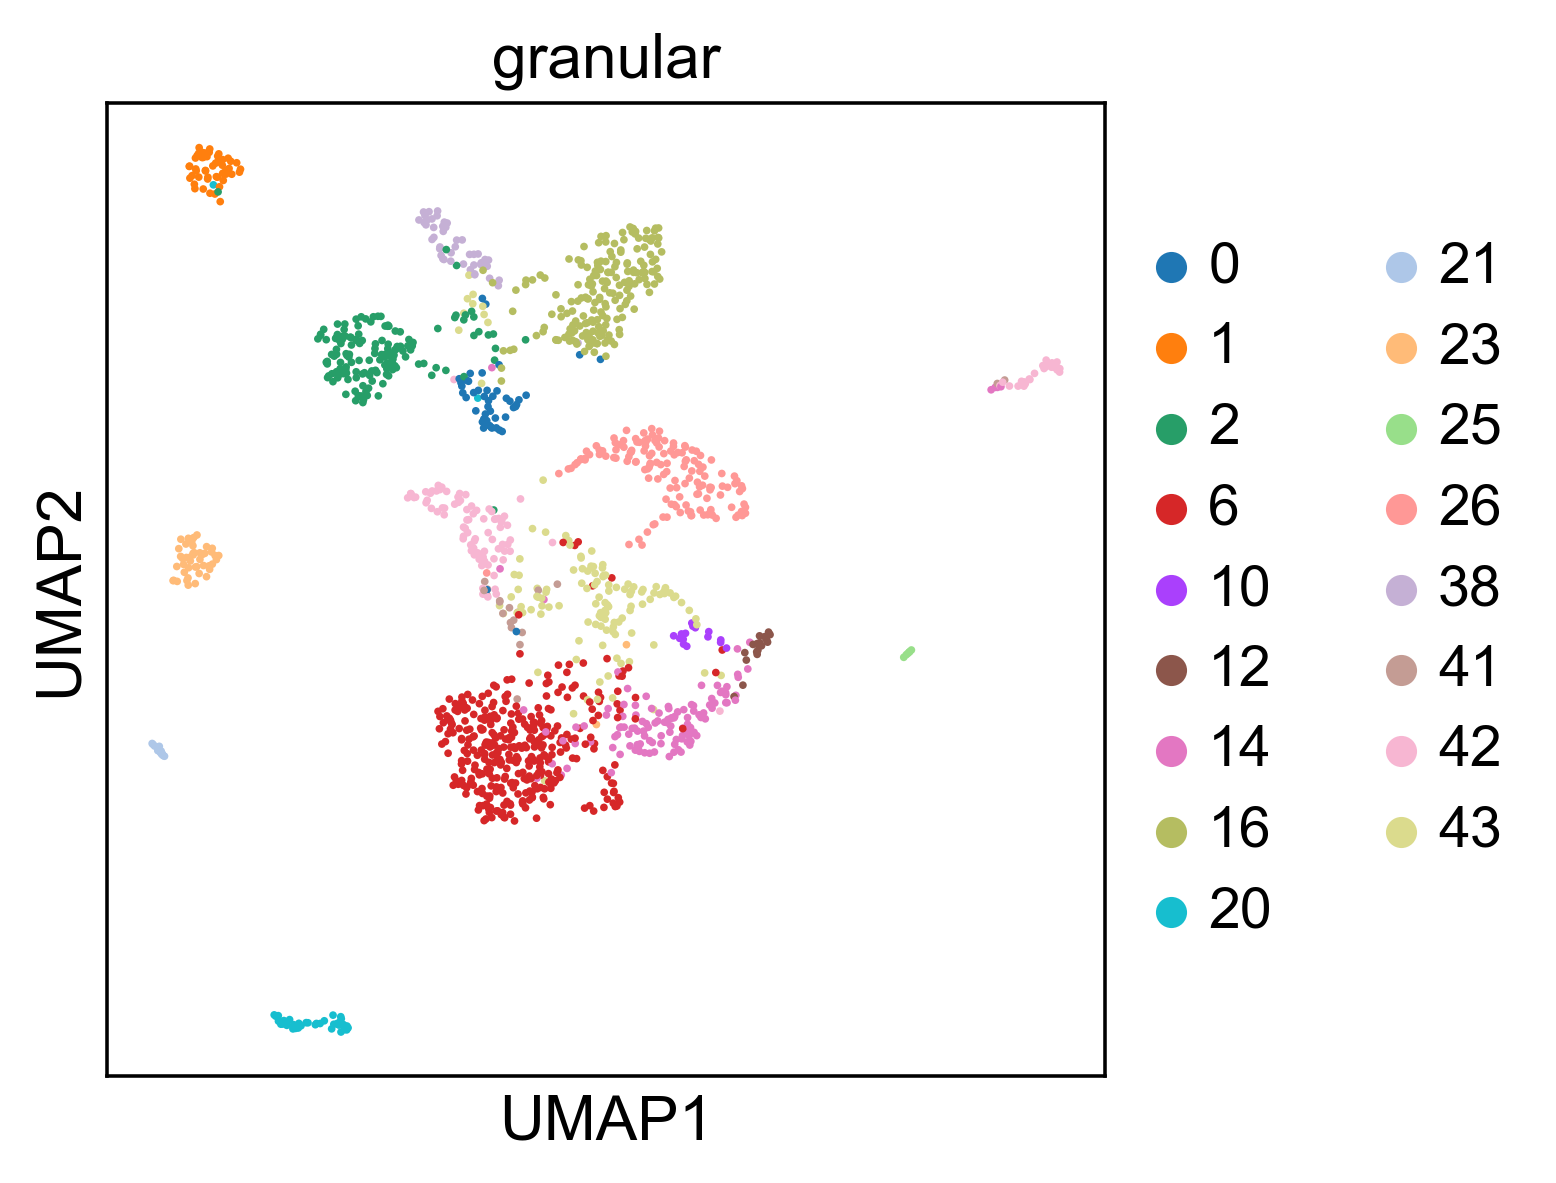

In [39]:

# sc.settings.set_figure_params(dpi=120, facecolor='white', )
# sc.settings.set_figure_params(figsize=(8,8), dpi=80, facecolor='white', )
sc.settings.set_figure_params(
    dpi=160,
    facecolor="white",
)
sc.pl.umap(bdata, color=["granular"], size=12)


In [31]:
sc.tl.louvain(bdata, )

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 14 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


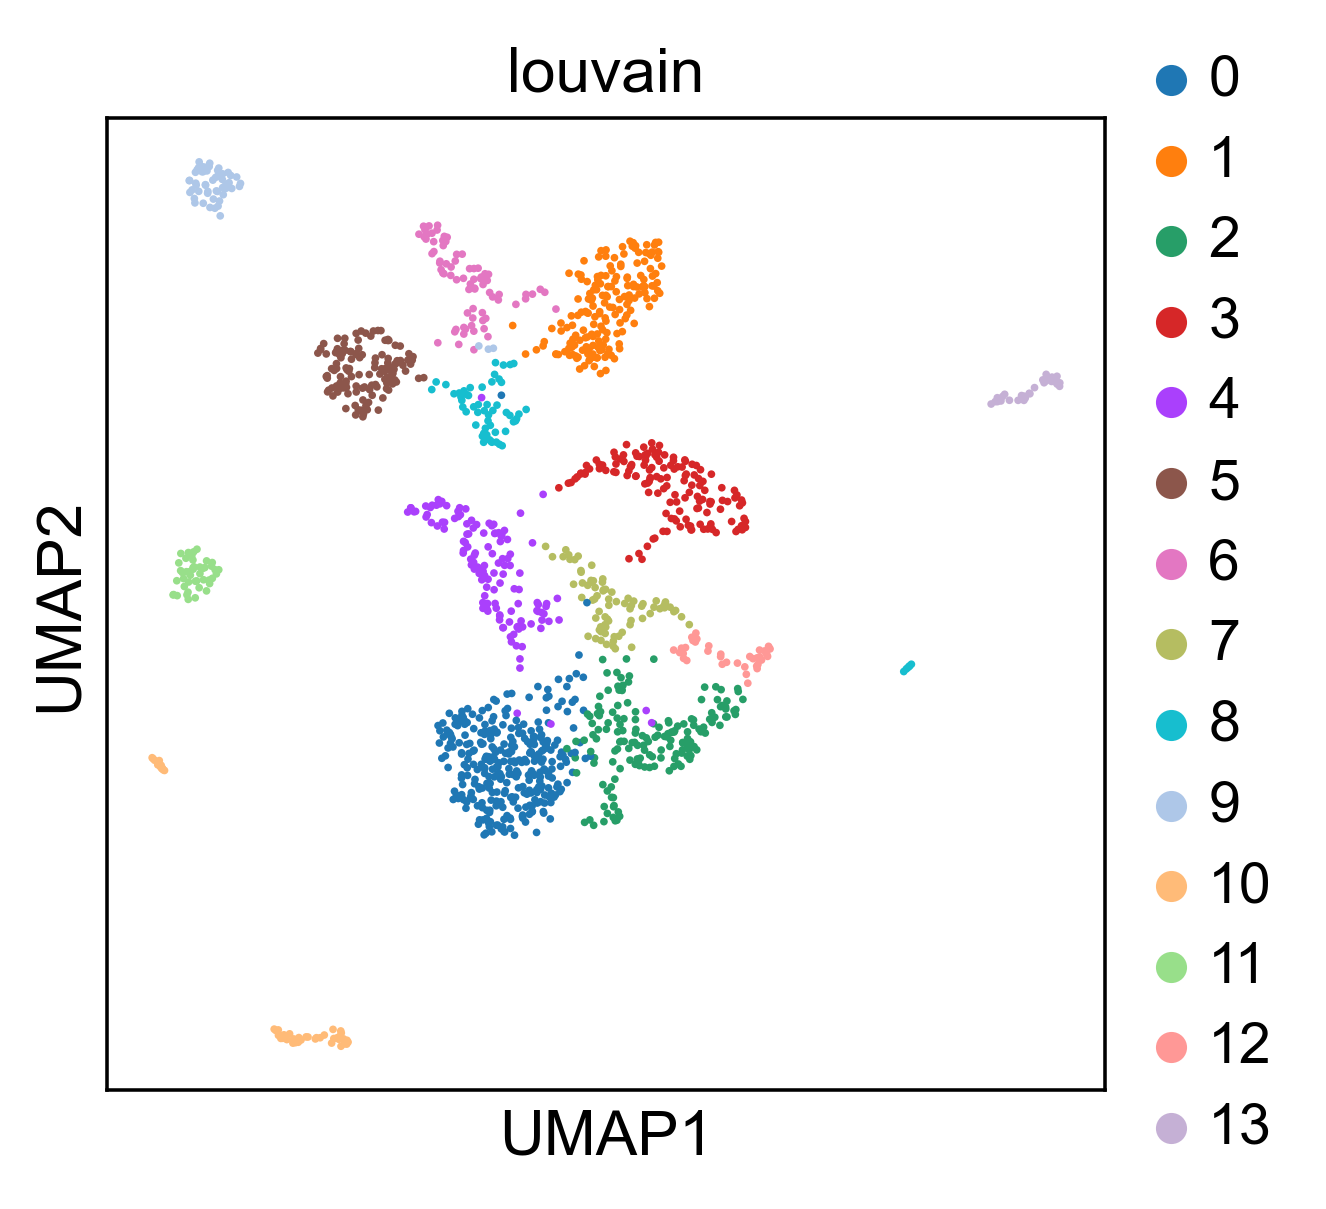

In [40]:
sc.pl.umap(bdata, color=["louvain"], size=12)


In [58]:
#bdata.obs["broad"] = adata.obs["Broad cell type"][-1500:]
adata.obs["broad"] = adata.obs["Broad cell type"]
bdata.obs["broad"] = list(adata.obs["broad"][-1500:])

/home/ykolb/miniconda3/envs/torch/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'broad' as categorical


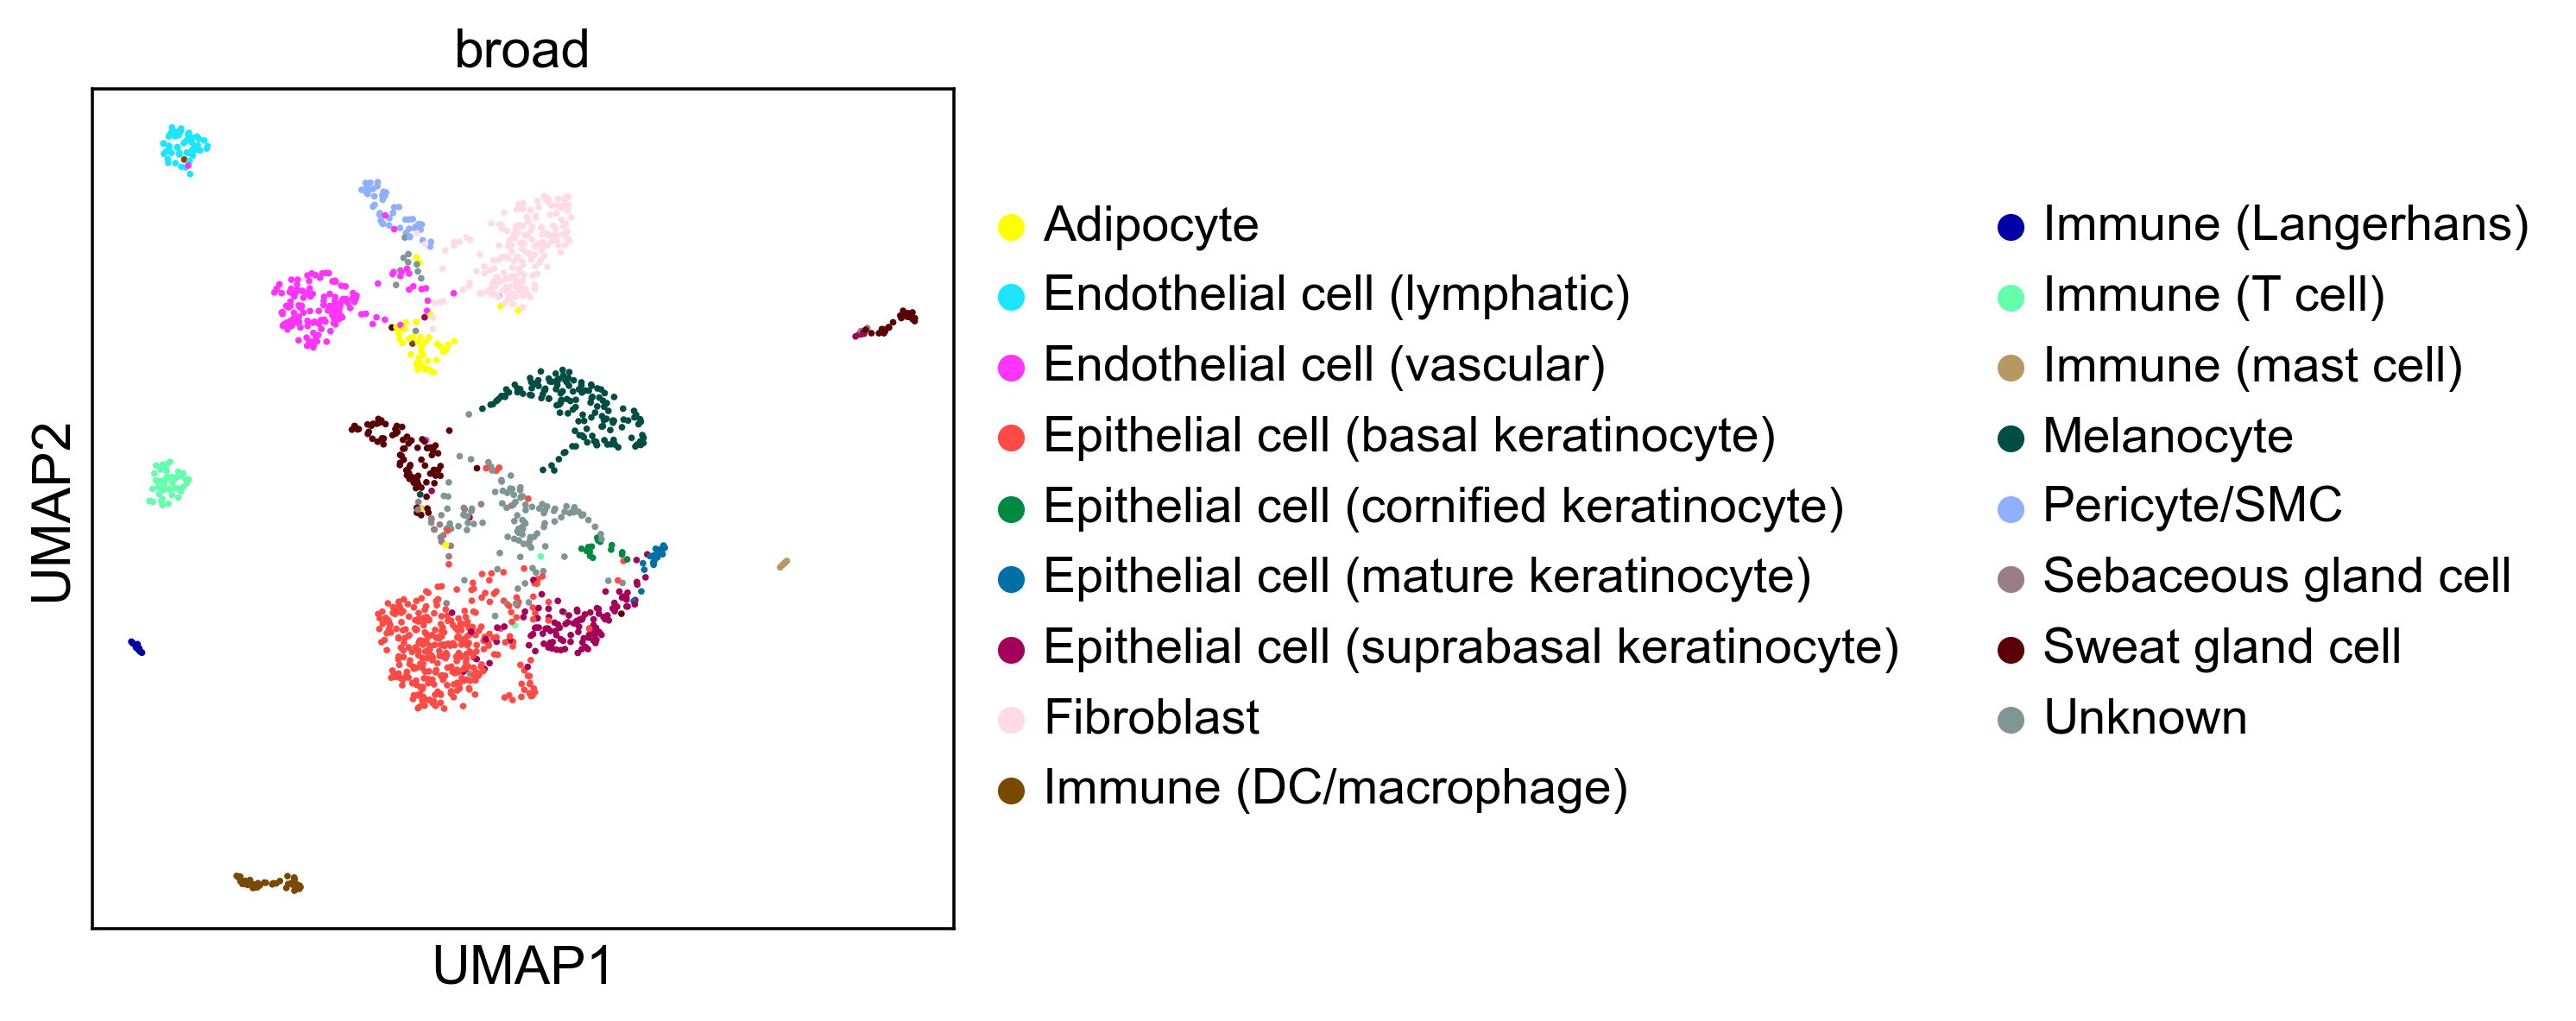

In [59]:
sc.pl.umap(bdata, color=["broad"], size=12)

In [50]:
bdata.obs["granular"]

0       43
1        6
2        2
3        2
4        6
        ..
1495    43
1496    16
1497    43
1498    38
1499    16
Name: granular, Length: 1500, dtype: category
Categories (17, object): ['0', '1', '2', '6', ..., '38', '41', '42', '43']

In [56]:
bdata.obs["broad"] = list(adata.obs["broad"][-1500:])

In [57]:
bdata.obs["broad"]

0                                    Unknown
1       Epithelial cell (basal keratinocyte)
2                Endothelial cell (vascular)
3                Endothelial cell (vascular)
4       Epithelial cell (basal keratinocyte)
                        ...                 
1495                                 Unknown
1496                              Fibroblast
1497                                 Unknown
1498                            Pericyte/SMC
1499                              Fibroblast
Name: broad, Length: 1500, dtype: object

In [61]:
Train.basicTrainLoop(
        model=model1500a,
        train_loader=unlabeled_loader,
        test_loader=None,
        num_epochs=15,
        lrs=[1e-4, 1e-3, 1e-3, 1e-4],
        #lrs=[1e-5, 1e-4, 1e-3, 1e-3, 1e-4, 1e-5],
        #lrs=[1e-5, 1e-5, 1e-5, 1e-5, 1e-5],
        wt=0,
        report_interval=5,
        #test_accuracy=True,
        )


epoch's lr =  0.0001
epoch 0
training phase
rec: 19154.298828125
total_loss: 19154.298828125

epoch 5
training phase
rec: 13048.474609375
total_loss: 13048.474609375

epoch 10
training phase
rec: 9223.5029296875
total_loss: 9223.5029296875

epoch's lr =  0.001
epoch 0
training phase
rec: 6662.3935546875
total_loss: 6662.3935546875

epoch 5
training phase
rec: 2113.328125
total_loss: 2113.328125

epoch 10
training phase
rec: 1794.95703125
total_loss: 1794.95703125

epoch's lr =  0.001
epoch 0
training phase
rec: 2113.61181640625
total_loss: 2113.61181640625

epoch 5
training phase
rec: 1905.812255859375
total_loss: 1905.812255859375

epoch 10
training phase
rec: 1955.994384765625
total_loss: 1955.994384765625

epoch's lr =  0.0001
epoch 0
training phase
rec: 2276.547119140625
total_loss: 2276.547119140625

epoch 5
training phase
rec: 1395.3843994140625
total_loss: 1395.3843994140625

epoch 10
training phase
rec: 1437.906982421875
total_loss: 1437.906982421875

done training


In [63]:
model1500a.cpu()
model1500a.eval()
output = model1500a(data[-1500:])
bdata.obsm["z2"] = output["z"].detach().numpy()
del output

In [64]:
sc.pp.neighbors(bdata, use_rep="z2", n_neighbors=9,)
sc.tl.umap(bdata,)


computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:01)


In [66]:
sc.tl.louvain(bdata, )


running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 16 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


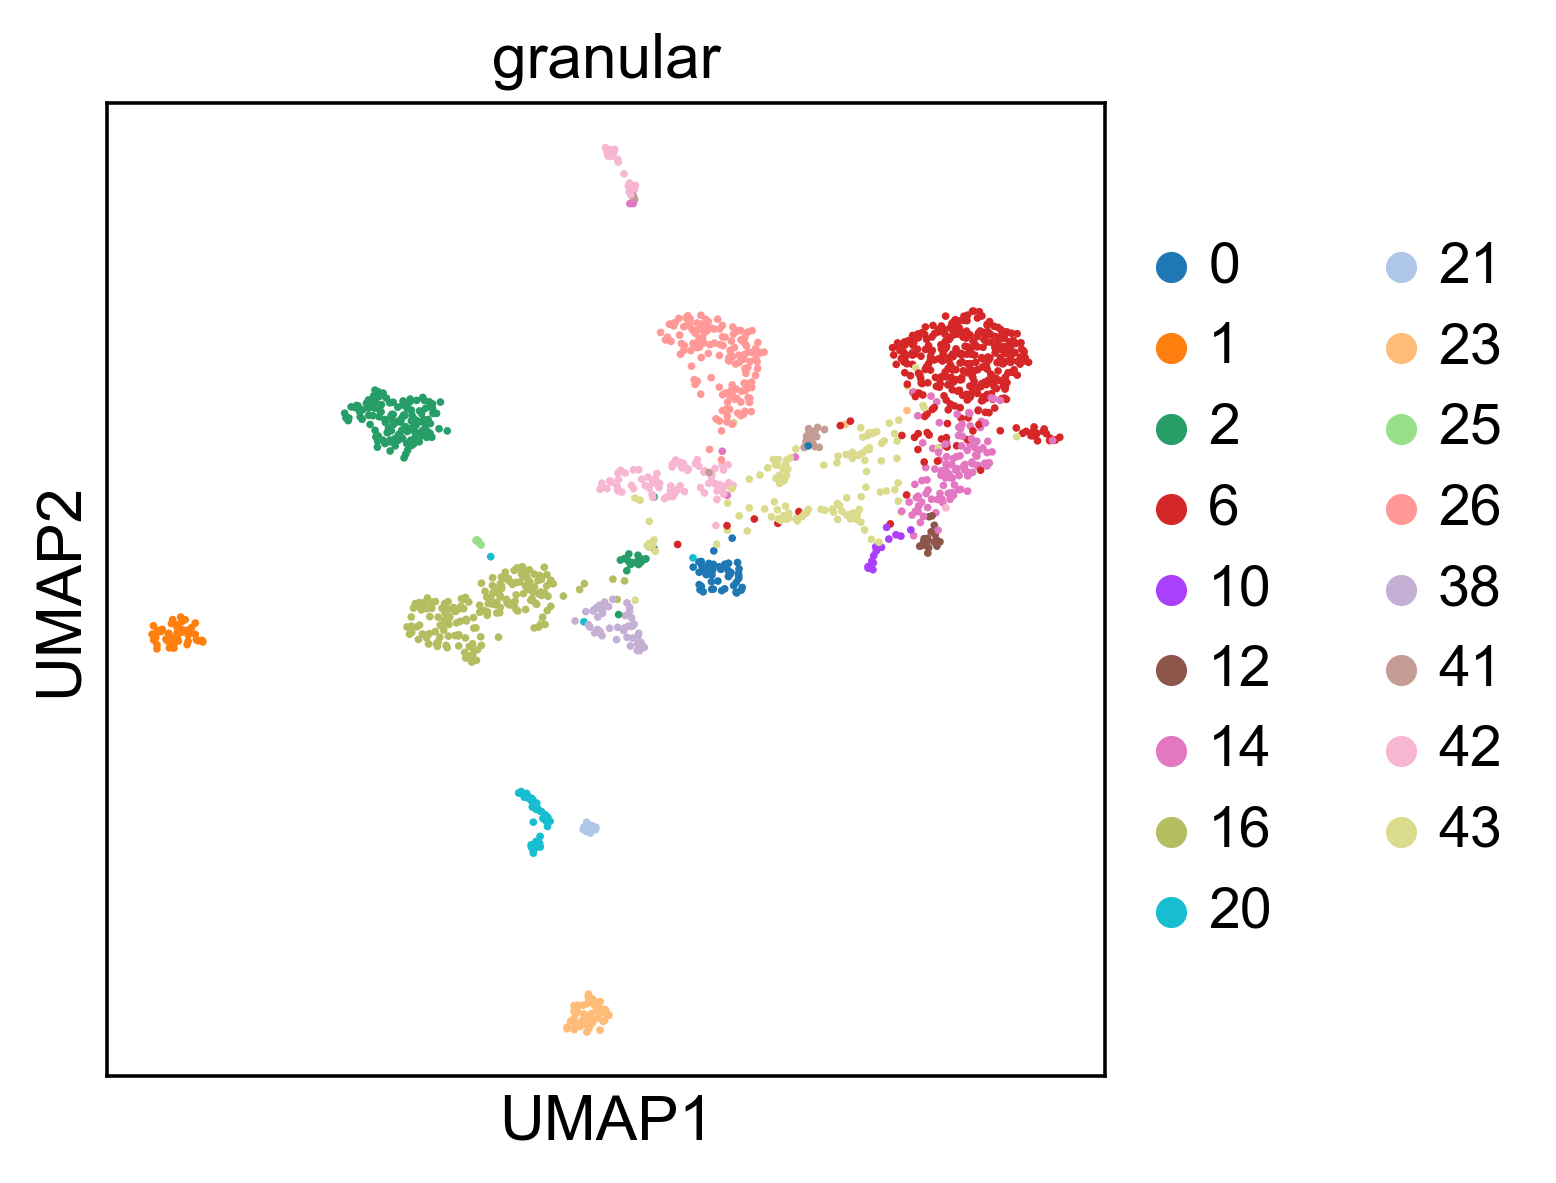

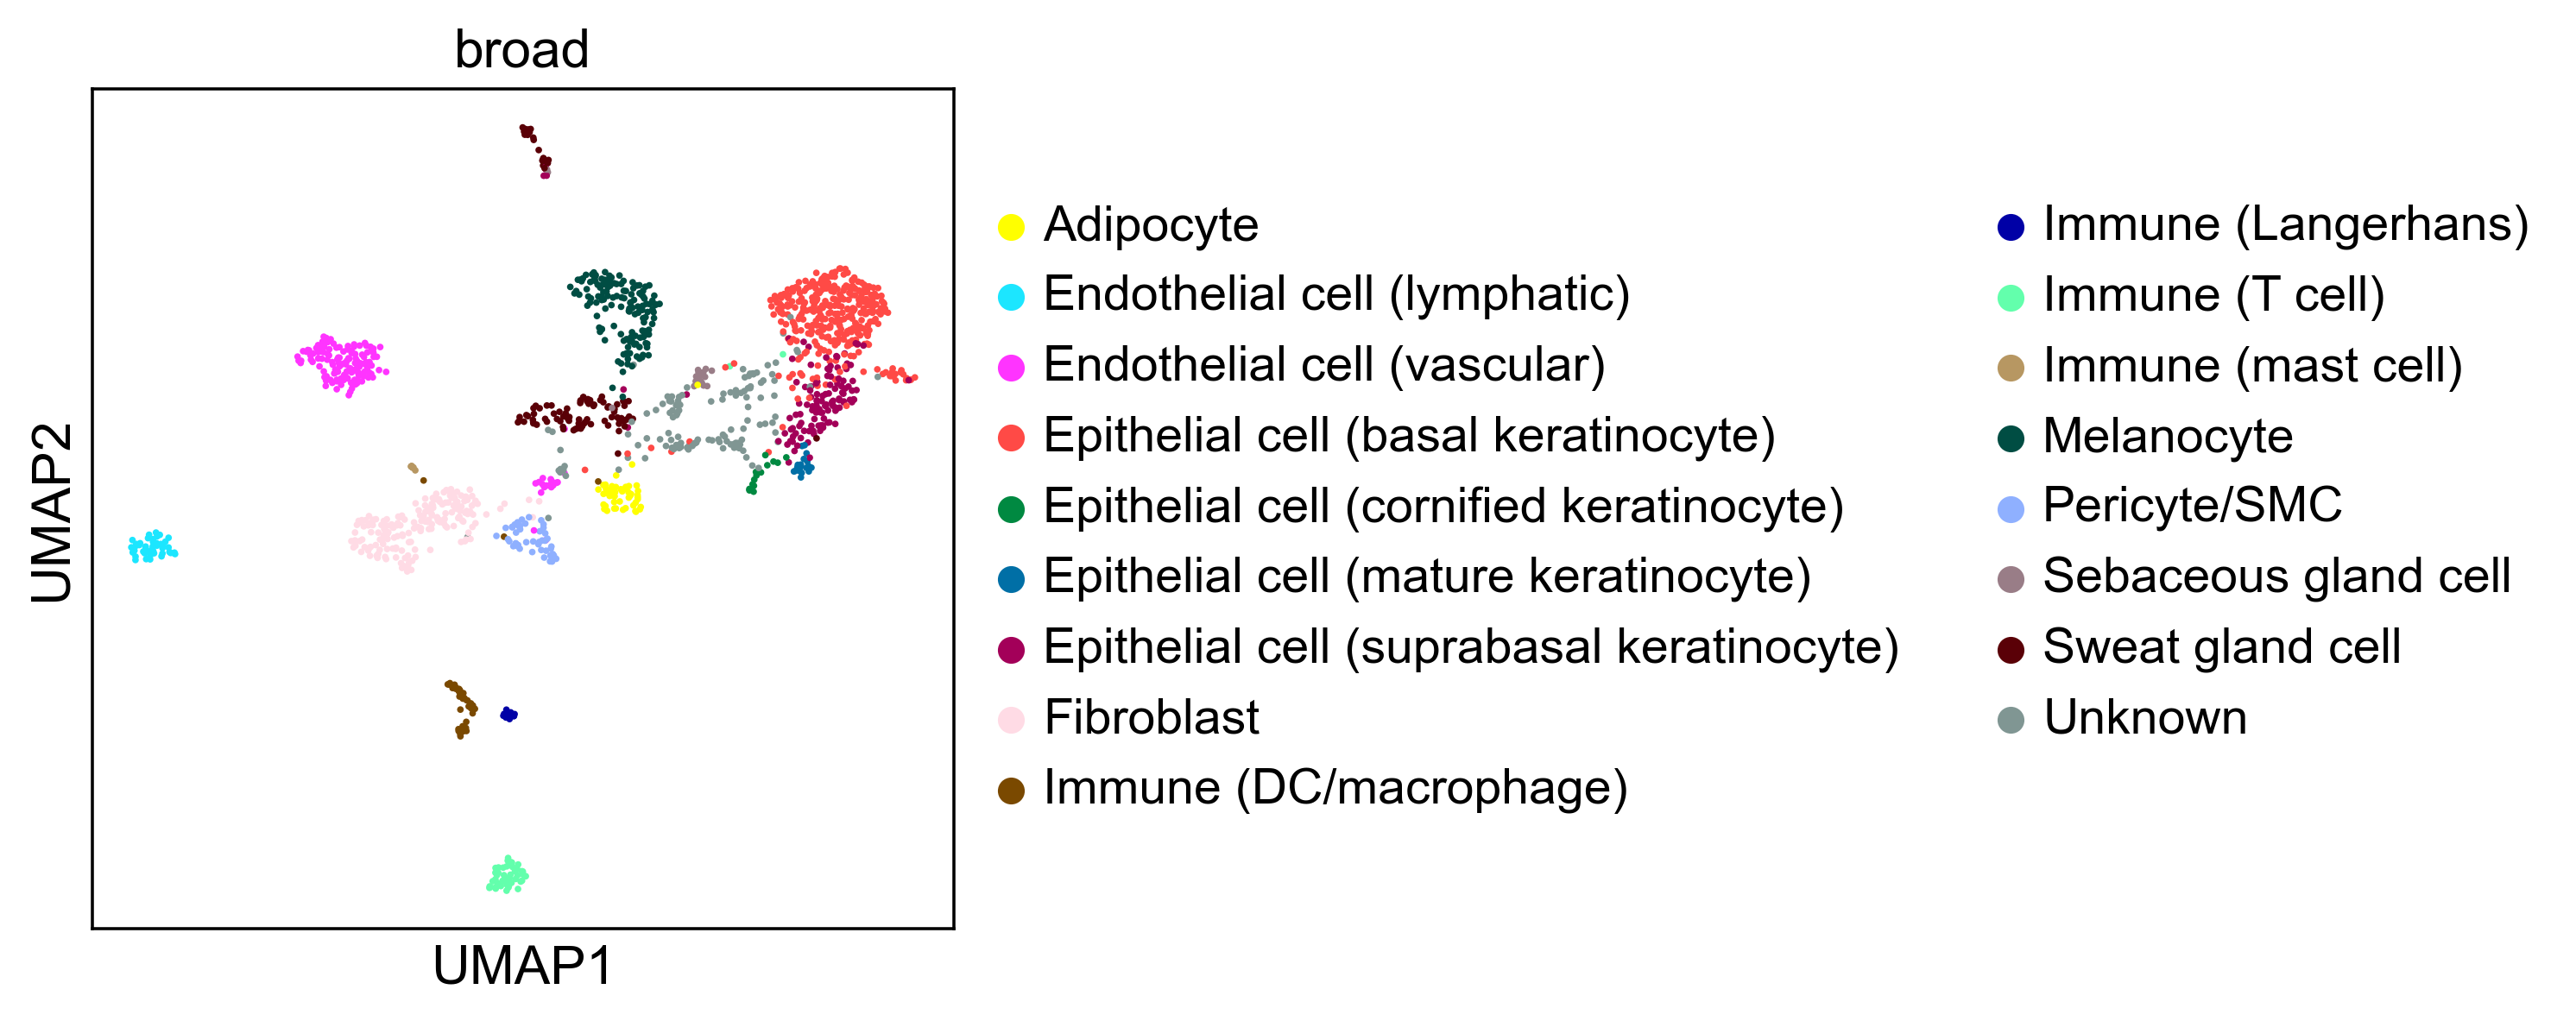

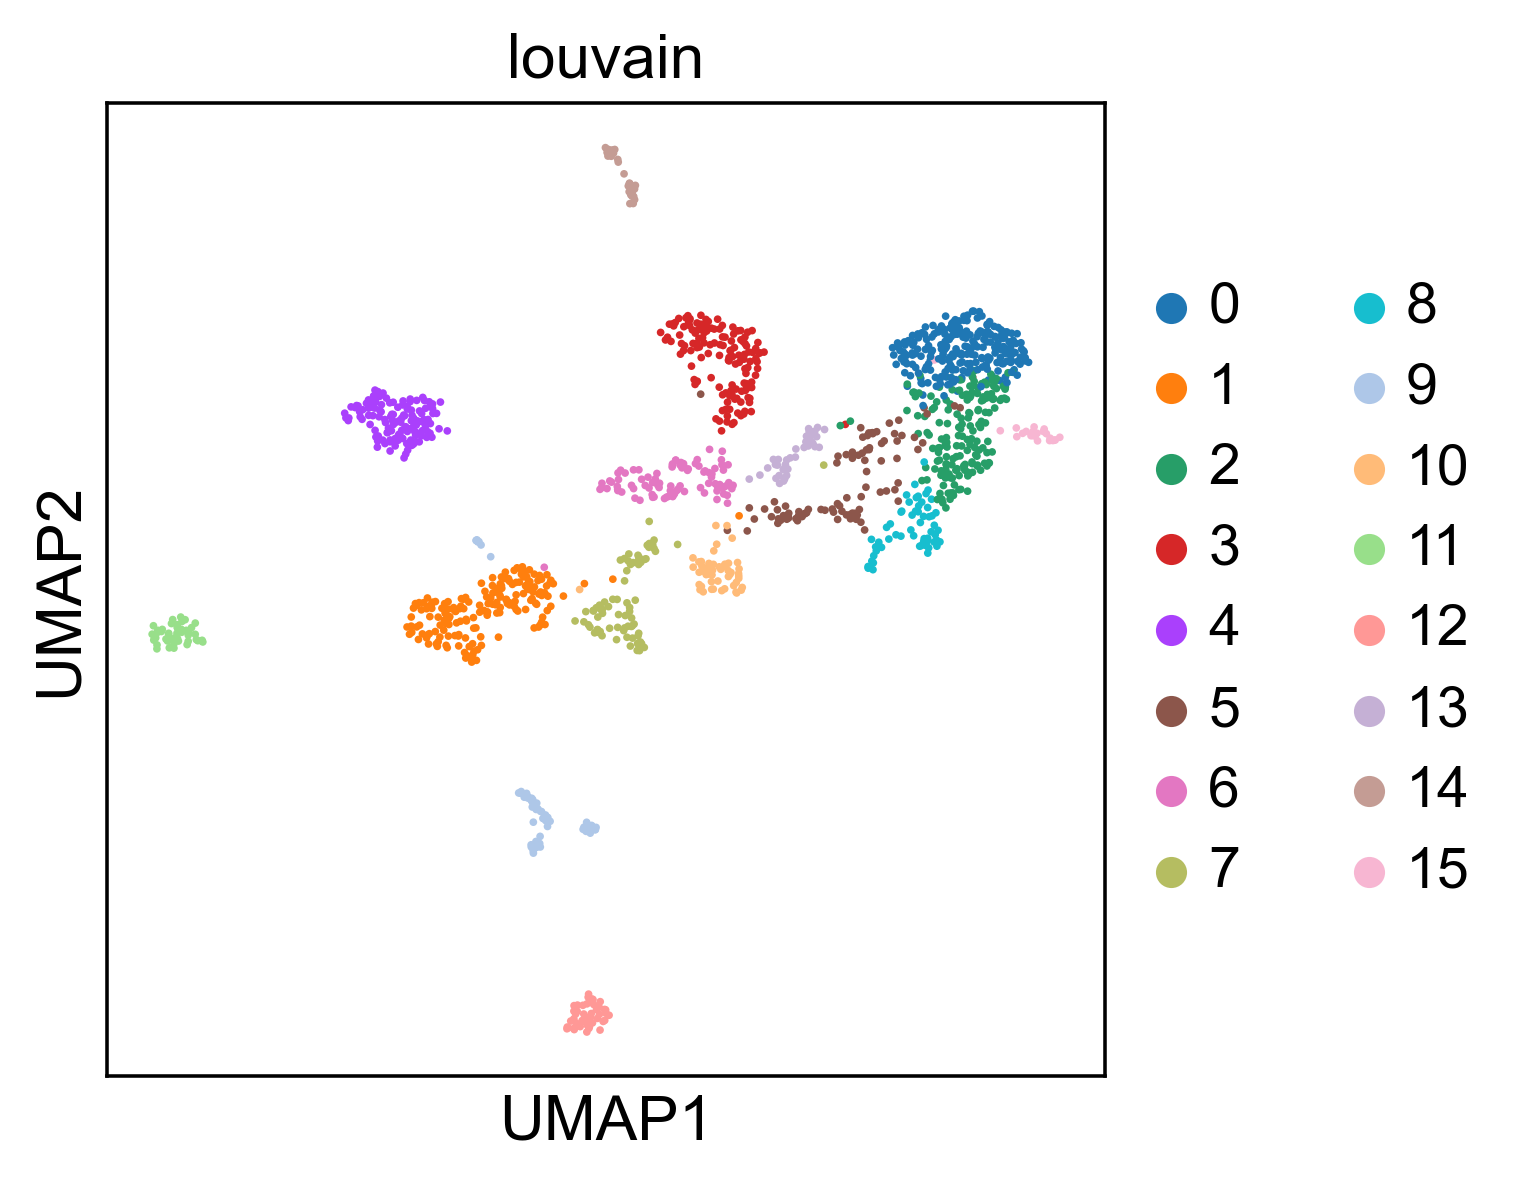

In [67]:
sc.pl.umap(bdata, color=["granular"], size=12)
sc.pl.umap(bdata, color=["broad"], size=12)
sc.pl.umap(bdata, color=["louvain"], size=12)


In [93]:
model1502a = M15.VAE_Dirichlet_GMM_Type1502(
    nx=adata.n_vars,
    nh=1024,
    nhp=1024,
    nhq=1024,
    nz=150,
    nw=100,
    numhidden=2,
    numhiddenp=2,
    numhiddenq=2,
    dropout=0.25,
    use_resnet=False,
    nclasses=labels.shape[1]*2,
    yscale=1e0,
    mi_scale=1e0,
    cc_scale=1e1,
    concentration=5e0,
    temperature=0.1,
    #restrict_w=False,
    restrict_w="lv",
    #do_cc=True,
    softargmax=False,
    activation=nn.LeakyReLU(),
        )
model1502a.apply(init_weights)


VAE_Dirichlet_GMM_Type1502(
  (Px): Sequential(
    (linear1): Linear(in_features=150, out_features=1024, bias=True)
    (dropout1): Dropout(p=0.25, inplace=False)
    (batchnorm1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation1): LeakyReLU(negative_slope=0.01)
    (linear2): Linear(in_features=1024, out_features=1024, bias=True)
    (dropout2): Dropout(p=0.25, inplace=False)
    (batchnorm2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation2): LeakyReLU(negative_slope=0.01)
    (output_layer): Linear(in_features=1024, out_features=17695, bias=True)
  )
  (Pz): Sequential(
    (linear1): Linear(in_features=100, out_features=1024, bias=True)
    (dropout1): Dropout(p=0.25, inplace=False)
    (batchnorm1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation1): LeakyReLU(negative_slope=0.01)
    (linear2): Linear(in_features=1024, out_features=

In [94]:
model1502b = M15.VAE_Dirichlet_GMM_Type1502(
    nx=adata.n_vars,
    nh=1024,
    nhp=1024,
    nhq=1024,
    nz=24,
    nw=12,
    numhidden=2,
    numhiddenp=2,
    numhiddenq=2,
    dropout=0.25,
    use_resnet=False,
    nclasses=labels.shape[1]*2,
    yscale=1e0,
    mi_scale=1e0,
    cc_scale=1e1,
    concentration=5e0,
    temperature=0.1,
    #restrict_w=False,
    restrict_w="lv",
    #do_cc=True,
    softargmax=False,
    activation=nn.LeakyReLU(),
        )
model1502b.apply(init_weights)


VAE_Dirichlet_GMM_Type1502(
  (Px): Sequential(
    (linear1): Linear(in_features=24, out_features=1024, bias=True)
    (dropout1): Dropout(p=0.25, inplace=False)
    (batchnorm1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation1): LeakyReLU(negative_slope=0.01)
    (linear2): Linear(in_features=1024, out_features=1024, bias=True)
    (dropout2): Dropout(p=0.25, inplace=False)
    (batchnorm2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation2): LeakyReLU(negative_slope=0.01)
    (output_layer): Linear(in_features=1024, out_features=17695, bias=True)
  )
  (Pz): Sequential(
    (linear1): Linear(in_features=12, out_features=1024, bias=True)
    (dropout1): Dropout(p=0.25, inplace=False)
    (batchnorm1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation1): LeakyReLU(negative_slope=0.01)
    (linear2): Linear(in_features=1024, out_features=10

In [ ]:
#Train.basicTandemTrainLoop(
Train.basicDuoTrainLoop(
    model1502a,
    model1502b,
    unlabeled_loader,
    None,
    num_epochs=15,
    #lrs = [1e-5, 1e-4, 1e-3, 1e-3, 1e-5],
    lrs = [1e-6, 1e-5, 1e-4, 1e-4, 1e-4, 1e-5],
    wt=0,
    report_interval=5,
    test_accuracy=True,
    mi_scale=5e1,
)

epoch's lr =  1e-06
epoch 0
training phase
rec: 19166.48828125
loss_z: 82.8343276977539
loss_w: 621.8154907226562
loss_cluster: -0.08403678238391876
loss_d: 504.53997802734375
loss_y_alt: 1.8101978302001953
loss_y_alt2: 0
total_loss: 20377.48828125
num_clusters: 0
rec: 19165.103515625
loss_z: 29.733549118041992
loss_w: 133.53790283203125
loss_cluster: -0.08827471733093262
loss_d: 526.551513671875
loss_y_alt: 1.8807309865951538
loss_y_alt2: 0
total_loss: 19856.806640625
num_clusters: 0
tandem_loss -0.06551742553710938

[ 5. 16. -1. 31. -1.  1. -1. -1. -1. 11. 29.  4. -1.  7.  5. 16. -1. -1.
 16. -1. -1. -1.  4. -1. -1. 33. -1. 16. -1. -1. -1. -1. -1.  5. 16. 16.
  5. 31. -1. -1. -1. -1. -1. 16. -1. 16. 25. 11. 23. 31. -1. -1. -1. 30.
 -1. -1. -1. -1. 16.  2.  2. 33. -1. -1.  2. -1.  5. -1. 16. -1. -1. -1.
 24. 16. -1.  7. 11. 16. -1. 31. 16. -1. -1.  4. 31. 30. -1.  5.] 
 -0.1950001912683289 
 [ 0.2         0.16216216 -1.          0.5        -1.          1.
 -1.         -1.         -1. 

In [88]:
model = M15.VAE_Dirichlet_GMM_Type1502(
    nx=adata.n_vars,
    nh=1024,
    nhp=1024,
    nhq=1024,
    #nz=60,
    nz=30,
    #nw=20,
    nw=10,
    numhidden=5,
    numhiddenp=5,
    numhiddenq=5,
    dropout=0.25,
    #use_resnet=False,
    #use_resnet=True,
    nclasses=labels.shape[1]*2,
    yscale=1e0,
    mi_scale=1e0,
    cc_scale=1e1,
    concentration=1.5e0,
    temperature=0.1,
    #restrict_w=False,
    #restrict_w="lv",
    #do_cc=True,
    bn=False,
    softargmax=False,
    activation=nn.LeakyReLU(),
        )
model.apply(init_weights)
Train.basicTrainLoop(
        model=model,
        train_loader=unlabeled_loader,
        test_loader=None,
        num_epochs=15,
        lrs=[1e-6, 1e-5, 1e-5, 1e-4, 1e-4, 1e-4, 1e-4],
        #lrs=[1e-5, 1e-4, 1e-3, 1e-3, 1e-4, 1e-5],
        #lrs=[1e-5, 1e-5, 1e-5, 1e-5, 1e-5],
        wt=0,
        report_interval=10,
        test_accuracy=True,
        )


epoch's lr =  1e-06
epoch 0
training phase
rec: 18721.63671875
loss_z: 3.683689832687378
loss_w: 1.1437914371490479
loss_cluster: -0.02546119876205921
loss_d: 7.893644332885742
loss_y_alt: 0.6453468203544617
loss_y_alt2: 0
total_loss: 18735.00390625
num_clusters: 0

[-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  2. -1. -1. -1.
 -1.  5. -1. 20. -1. -1.  2. 35. -1. -1. -1. -1. -1.  4. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. 16. -1. -1. -1. -1. -1.  1. 23. -1. -1. -1. -1.
 -1. -1.  0. -1. -1. 16. -1. -1. -1. 11. 33. -1. -1. -1. -1.  7.  2. -1.
  7. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  7. -1.] 
 -0.7309400957312936 
 [-1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.          0.20588235 -1.         -1.         -1.
 -1.          0.17391304 -1.          0.25       -1.         -1.
  0.66666667  1.         -1.         -1.         -1.         -1.
 -1.          0.5        -

In [89]:
Train.basicTrainLoop(
        model=model,
        train_loader=unlabeled_loader,
        test_loader=None,
        num_epochs=30,
        lrs=[1e-3, 1e-4, 1e-5,],
        #lrs=[1e-5, 1e-4, 1e-3, 1e-3, 1e-4, 1e-5],
        #lrs=[1e-5, 1e-5, 1e-5, 1e-5, 1e-5],
        wt=0,
        report_interval=9,
        test_accuracy=True,
        )


epoch's lr =  0.001
epoch 0
training phase
rec: 2045.405029296875
loss_z: 12.624433517456055
loss_w: 0.39971956610679626
loss_cluster: -0.011430848389863968
loss_d: 0.0018161858897656202
loss_y_alt: 0.3595568537712097
loss_y_alt2: 0
total_loss: 2058.79052734375
num_clusters: 0

[-1. 31. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. 16. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1.  7. -1. -1. -1.  7. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 33. -1. -1. -1. -1. -1. -1. -1. -1.  2. -1. -1. -1. -1. -1. -1.] 
 -0.9049433350167931 
 [-1.          0.17177914 -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -1.         -1.          1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -1.         -

ValueError: Expected parameter concentration (Tensor of shape (256, 88)) of distribution Dirichlet(concentration: torch.Size([256, 88])) to satisfy the constraint IndependentConstraint(GreaterThan(lower_bound=0.0), 1), but found invalid values:
tensor([[1.5152, 1.5156, 1.5170,  ..., 1.5155, 1.5167, 1.5146],
        [1.5068, 1.5069, 1.5080,  ..., 1.5066, 1.5081, 1.5061],
        [1.5157, 1.5155, 1.5172,  ..., 1.5159, 1.5176, 1.5149],
        ...,
        [1.5125, 1.5129, 1.5146,  ..., 1.5128, 1.5136, 1.5120],
        [1.5173, 1.5179, 1.5201,  ..., 1.5174, 1.5190, 1.5169],
        [1.5092, 1.5101, 1.5119,  ..., 1.5097, 1.5110, 1.5096]],
       device='cuda:0', grad_fn=<ExpBackward0>)

In [15]:
reload(M15)

True


<module 'gmmvae15' from '/home/ykolb/my_gits/mg22/gmmvae15.py'>

In [11]:
model705 = M7.VAE_Dirichlet_Type705(
    nx=adata.
    n_vars,
    nh=1024,
    nz=64,
    nw=15,
    nclasses=enc_ct.classes_.size,)
model705.apply(init_weights)



VAE_Dirichlet_Type705(
  (Px): Sequential(
    (linear1): Linear(in_features=64, out_features=1024, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
    (batchnorm1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation1): LeakyReLU(negative_slope=0.01)
    (linear2): Linear(in_features=1024, out_features=1024, bias=True)
    (dropout2): Dropout(p=0.2, inplace=False)
    (batchnorm2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation2): LeakyReLU(negative_slope=0.01)
    (output_layer): Linear(in_features=1024, out_features=17695, bias=True)
  )
  (Pz): Sequential(
    (linear1): Linear(in_features=15, out_features=1024, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
    (batchnorm1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation1): LeakyReLU(negative_slope=0.01)
    (linear2): Linear(in_features=1024, out_features=1024, bias

In [33]:
reload(M15)
model1502 = M15.VAE_Dirichlet_GMM_Type1502temp(
    nx=adata.n_vars,
    nh=1024,
    nhp=1024,
    nhq=1024,
    nz=64,
    nw=15,
    numhidden=2,
    numhiddenp=2,
    numhiddenq=2,
    #dropout=0.20,
    dropout=0.30,
    use_resnet=False,
    nclasses=labels.shape[1]*2,
    yscale=1e0,
    mi_scale=1e0,
    cc_scale=1e1,
    #concentration=5e0,
    #concentration=1e-2,
    temperature=0.1,
    #restrict_w=False,
    restrict_w="lv",
    restrict_z="lv",
    do_cc=False,
    softargmax=False,
    eps=1e-6,
    activation=nn.LeakyReLU(),
        )
model1502.apply(init_weights)


True


VAE_Dirichlet_GMM_Type1502temp(
  (Px): Sequential(
    (linear1): Linear(in_features=64, out_features=1024, bias=True)
    (dropout1): Dropout(p=0.3, inplace=False)
    (batchnorm1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation1): LeakyReLU(negative_slope=0.01)
    (linear2): Linear(in_features=1024, out_features=1024, bias=True)
    (dropout2): Dropout(p=0.3, inplace=False)
    (batchnorm2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation2): LeakyReLU(negative_slope=0.01)
    (output_layer): Linear(in_features=1024, out_features=17695, bias=True)
  )
  (Pz): Sequential(
    (linear1): Linear(in_features=15, out_features=1024, bias=True)
    (dropout1): Dropout(p=0.3, inplace=False)
    (batchnorm1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation1): LeakyReLU(negative_slope=0.01)
    (linear2): Linear(in_features=1024, out_features=1

In [34]:
#Train.basicTrainLoop(
#        model=model705,
#        train_loader=unlabeled_loader,
#        test_loader=None,
#        num_epochs=5,
#        lrs=[1e-3, ],
#        #lrs=[1e-3, 1e-4, 1e-5,],
#        #lrs=[1e-5, 1e-4, 1e-3, 1e-3, 1e-4, 1e-5],
#        #lrs=[1e-5, 1e-5, 1e-5, 1e-5, 1e-5],
#        wt=0,
#        report_interval=9,
#        test_accuracy=True,
#        )


In [35]:
Train.basicTrainLoop(
        model=model1502,
        train_loader=unlabeled_loader,
        test_loader=None,
        num_epochs=10,
        lrs=[1e-3, ],
        #lrs=[1e-3, 1e-4, 1e-5,],
        #lrs=[1e-5, 1e-4, 1e-3, 1e-3, 1e-4, 1e-5],
        #lrs=[1e-5, 1e-5, 1e-5, 1e-5, 1e-5],
        wt=0,
        report_interval=3,
        test_accuracy=True,
        )


epoch's lr =  0.001
epoch 0
training phase
rec: 19170.158203125
loss_z: 1350.4764404296875
loss_w: 147.14334106445312
loss_cluster: -0.08029644936323166
loss_d: 48.02593994140625
loss_y_alt: 1.7991464138031006
loss_y_alt2: 0
total_loss: 20717.6015625
num_clusters: 0

[11. -1. -1. -1. 16. 40. -1. -1. 16. -1. -1. -1. 16. -1. -1. 16. -1. -1.
 11. 38. -1.  1.  4. 16. -1. -1. -1. 31.  5. -1.  2. -1. -1. -1.  9. -1.
  2. -1. -1. 16.  2. 11. -1. -1. -1. -1. -1.  2. -1. -1. -1. -1.  5. -1.
 33.  9. -1. 31. 16.  5.  5. -1.  5. -1. -1. 16. -1. -1. -1. -1. -1. -1.
 13. -1. 16. -1. -1. -1. 20. -1. 16. -1. 32. -1. -1. -1.  2. -1.] 
 -0.3799069836619244 
 [ 0.4        -1.         -1.         -1.          0.23809524  1.
 -1.         -1.          0.5        -1.         -1.         -1.
  1.         -1.         -1.          0.33333333 -1.         -1.
  1.          1.         -1.          0.25        0.2         0.20833333
 -1.         -1.         -1.          0.29166667  0.33333333 -1.
  0.2        -1. 

KeyboardInterrupt: 

In [45]:
reload(M15)
model1503a = M15.VAE_GMM_Type1503(
    nx=adata.n_vars,
    nh=1024,
    nhp=1024,
    nhq=1024,
    #nz=64,
    nz=44,
    #nw=15,
    nw=22,
    numhidden=2,
    numhiddenp=2,
    numhiddenq=2,
    #dropout=0.20,
    dropout=0.30,
    use_resnet=False,
    nclasses=labels.shape[1]*2,
    yscale=1e0,
    mi_scale=1e0,
    cc_scale=1e1,
    temperature=0.1,
    #restrict_w=False,
    #restrict_w="lv",
    #restrict_z="lv",
    do_cc=False,
    softargmax=False,
    eps=1e-6,
    activation=nn.LeakyReLU(),
        )
model1503a.apply(init_weights)


True


VAE_GMM_Type1503(
  (Px): Sequential(
    (linear1): Linear(in_features=44, out_features=1024, bias=True)
    (dropout1): Dropout(p=0.3, inplace=False)
    (batchnorm1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation1): LeakyReLU(negative_slope=0.01)
    (linear2): Linear(in_features=1024, out_features=1024, bias=True)
    (dropout2): Dropout(p=0.3, inplace=False)
    (batchnorm2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation2): LeakyReLU(negative_slope=0.01)
    (output_layer): Linear(in_features=1024, out_features=17695, bias=True)
  )
  (Pz): Sequential(
    (linear1): Linear(in_features=22, out_features=1024, bias=True)
    (dropout1): Dropout(p=0.3, inplace=False)
    (batchnorm1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation1): LeakyReLU(negative_slope=0.01)
    (linear2): Linear(in_features=1024, out_features=1024, bias=True

In [39]:
Train.basicTrainLoop(
        model=model1503a,
        train_loader=unlabeled_loader,
        test_loader=None,
        num_epochs=10,
        lrs=[1e-3, ],
        #lrs=[1e-3, 1e-4, 1e-5,],
        #lrs=[1e-5, 1e-4, 1e-3, 1e-3, 1e-4, 1e-5],
        #lrs=[1e-5, 1e-5, 1e-5, 1e-5, 1e-5],
        wt=0,
        report_interval=3,
        test_accuracy=True,
        )


epoch's lr =  0.001
epoch 0
training phase
rec: 19188.65625
loss_z: 52.55775451660156
loss_w: 10.857166290283203
loss_cluster: -0.07709599286317825
loss_y: 0.10473321378231049
total_loss: 19252.177734375
num_clusters: 0

[29. -1. -1. -1.  7.  2. -1. -1.  2. -1. 16. -1. -1. 33. -1. -1. -1.  7.
 -1.  2. -1. 20. -1. -1. -1. -1. -1. -1. -1. -1. -1.  2.  2. -1.  7. 20.
  7. 11. -1. -1. -1. 31. -1. -1.  2. -1. -1. 31.  7.  2. -1. -1. -1. 24.
  2. -1. -1.  2. -1. 11.  4. 33. 33. 16. -1. 11. -1. 20.  7. -1. -1. -1.
  7. 30. -1. 20. -1.  5. -1. -1.  4.  5.  2.  2. -1.  5. -1. 11.] 
 -0.28381487158979823 
 [ 1.         -1.         -1.         -1.          0.6         1.
 -1.         -1.          0.33333333 -1.          0.4        -1.
 -1.          0.33333333 -1.         -1.         -1.          0.21428571
 -1.          1.         -1.          0.28571429 -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -1.          0.33333333  0.5        -1.          1.          1

In [46]:
reload(M15)
model1503b = M15.VAE_GMM_Type1503(
    nx=adata.n_vars,
    nh=1024,
    nhp=1024,
    nhq=1024,
    nz=64,
    nw=32,
    numhidden=2,
    numhiddenp=2,
    numhiddenq=4,
    #dropout=0.20,
    dropout=0.30,
    use_resnet=False,
    nclasses=labels.shape[1]*2,
    yscale=1e0,
    mi_scale=1e0,
    cc_scale=1e1,
    temperature=0.1,
    #restrict_w=False,
    #restrict_w="lv",
    #restrict_z="lv",
    do_cc=False,
    softargmax=False,
    eps=1e-6,
    activation=nn.LeakyReLU(),
        )
model1503b.apply(init_weights)


True


VAE_GMM_Type1503(
  (Px): Sequential(
    (linear1): Linear(in_features=64, out_features=1024, bias=True)
    (dropout1): Dropout(p=0.3, inplace=False)
    (batchnorm1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation1): LeakyReLU(negative_slope=0.01)
    (linear2): Linear(in_features=1024, out_features=1024, bias=True)
    (dropout2): Dropout(p=0.3, inplace=False)
    (batchnorm2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation2): LeakyReLU(negative_slope=0.01)
    (output_layer): Linear(in_features=1024, out_features=17695, bias=True)
  )
  (Pz): Sequential(
    (linear1): Linear(in_features=32, out_features=1024, bias=True)
    (dropout1): Dropout(p=0.3, inplace=False)
    (batchnorm1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation1): LeakyReLU(negative_slope=0.01)
    (linear2): Linear(in_features=1024, out_features=1024, bias=True

In [44]:
Train.basicTrainLoop(
        model=model1503b,
        train_loader=unlabeled_loader,
        test_loader=None,
        num_epochs=5,
        lrs=[1e-5, 1e-3, 1e-3, ],
        #lrs=[1e-3, 1e-4, 1e-5,],
        #lrs=[1e-5, 1e-4, 1e-3, 1e-3, 1e-4, 1e-5],
        #lrs=[1e-5, 1e-5, 1e-5, 1e-5, 1e-5],
        wt=0,
        report_interval=5,
        test_accuracy=True,
        )


epoch's lr =  1e-05
epoch 0
training phase
rec: 19191.17578125
loss_z: 45.169677734375
loss_w: 20.00769805908203
loss_cluster: -0.07891823351383209
loss_y: 0.11549670994281769
total_loss: 19256.46875
num_clusters: 0

[-1. 11. -1. 16. -1. -1. -1. 20.  5. -1. -1. -1. -1. -1. 33. -1. 33. -1.
 -1. -1. -1.  5.  2. -1. -1. -1.  2. -1. -1. -1. 24. -1. -1.  7. -1. -1.
 -1. 33. -1. -1. -1. -1. -1. -1. -1. 11. -1. -1. -1. 11. 40. -1.  7. 33.
 -1. 16. -1. 16. -1. -1.  5. -1. -1. -1. -1. -1. -1. -1. -1. -1. 16. -1.
 -1.  1. -1. 16.  2. -1. -1.  2.  9. -1. -1. -1. -1.  2. -1. -1.] 
 -0.5307104435533119 
 [-1.          0.3        -1.          0.27272727 -1.         -1.
 -1.          0.33333333  0.25       -1.         -1.         -1.
 -1.         -1.          1.         -1.          0.5        -1.
 -1.         -1.         -1.          0.20689655  0.11111111 -1.
 -1.         -1.          0.14285714 -1.         -1.         -1.
  1.         -1.         -1.          0.5        -1.         -1.
 -1.       

In [49]:
Train.basicDuoTrainLoop(
    model1503a,
    model1503b,
    unlabeled_loader,
    None,
    num_epochs=5,
    lrs = [1e-5, 1e-4, 1e-3, 1e-3, 1e-5],
    #lrs = [1e-5, 1e-4, 1e-3, 1e-3, 1e-5],
    #lrs = [1e-6, 1e-5, 1e-4, 1e-4, 1e-4, 1e-5],
    wt=0,
    report_interval=5,
    test_accuracy=True,
    mi_scale=5e1,
)


epoch's lr =  1e-05
epoch 0
training phase
rec: 2012.8697509765625
loss_z: 14.923772811889648
loss_w: 2.14931583404541
loss_cluster: -0.9839835166931152
loss_y: 0.4231676459312439
total_loss: 2030.3660888671875
num_clusters: 77
rec: 2046.3397216796875
loss_z: 11.570430755615234
loss_w: 3.2695577144622803
loss_cluster: -0.9957505464553833
loss_y: 0.455872118473053
total_loss: 2061.635498046875
num_clusters: 74
tandem_loss -194.50547790527344

[20. -1.  7.  7.  2. -1.  7.  2.  7. 38. -1. 16. 11. -1. 16.  9.  7. 16.
  9. 11. -1. 33.  2. 31. 16. 16.  2.  0. 16.  5.  2. 16. 16.  2. 16. 16.
  5.  2. 24. 16. -1.  2. 29. -1. 20. 20. 33.  2. -1.  2. 11. -1. 29. 16.
 11. 16. 16.  2. 23.  2. -1. 24. 20. -1. 20. 16. 33. 38. -1. -1. 11.  7.
 16.  2. -1. 16. -1. -1. 33.  2. 35. 23. 30.  2. 29.  4.  1. 16.] 
 0.56620670995671 
 [ 1.         -1.          0.9         1.          1.         -1.
  1.          1.          1.          0.6        -1.          1.
  1.         -1.          1.          1.     

In [48]:
reload(M15)
model = M15.VAE_GMM_Type1503(
    nx=adata.n_vars,
    nh=1024*3,
    nhp=1024*3,
    nhq=1024*3,
    nz=44,
    nw=22,
    numhidden=2,
    numhiddenp=2,
    numhiddenq=2,
    dropout=0.2,
    use_resnet=False,
    nclasses=labels.shape[1]*2,
    yscale=1e0,
    mi_scale=1e0,
    cc_scale=1e1,
    temperature=0.1,
    restrict_w=True,
    reclosstype="mse",
    #do_cc=True,
    softargmax=False,
    activation=nn.LeakyReLU(),
        )
model.apply(init_weights)



True
epoch's lr =  1e-05
epoch 0
training phase
rec: 7445.4404296875
loss_z: 51.8116455078125
loss_w: 4.279596328735352
loss_cluster: -0.08674982190132141
loss_y: 0.13366468250751495
total_loss: 7501.66552734375
num_clusters: 0

[-1. -1. -1.  2. 16. -1. 11. -1. 16.  7. -1. -1. -1. -1. -1.  5. 20.  4.
 -1. 38. -1.  1. 31. -1.  2. -1. -1.  4. -1. -1. 38. -1. -1. -1. 16. -1.
 -1. 16. 23.  7. -1. -1. -1. -1. 31. -1. -1.  5. 31. -1. -1. -1. -1. -1.
 -1. -1.  1. -1. -1.  7. -1. -1. -1. -1.  2. -1.  2. -1. -1. 24. -1. -1.
 -1. -1. -1. -1. -1. 16. 16. -1. -1. -1.  7. 16. -1. -1. -1. -1.] 
 -0.473727566940819 
 [-1.         -1.         -1.          0.23076923  1.         -1.
  0.25       -1.          0.38461538  0.33333333 -1.         -1.
 -1.         -1.         -1.          0.30769231  1.          0.25
 -1.          1.         -1.          1.          0.39130435 -1.
  0.17647059 -1.         -1.          1.         -1.         -1.
  0.25       -1.         -1.         -1.          0.33333333 -1

In [ ]:
Train.basicTrainLoop(
        #model=model1500a,
        #model=model1501a,
        #model=model1502a,
        #model=model1503a,
        model=model,
        train_loader=unlabeled_loader,
        test_loader=None,
        num_epochs=30,
        lrs=[1e-5,1e-4,1e-3, 1e-4, 1e-5],
        #lrs=[1e-5, 1e-5, 1e-5, 1e-5, 1e-5],
        wt=0,
        report_interval=5,
        test_accuracy=True,
        )


epoch's lr =  1e-05
epoch 0
training phase
rec: 3522.64697265625
loss_z: 22.321720123291016
loss_w: 2.4743356704711914
loss_cluster: -0.9999985098838806
loss_y: 0.8668545484542847
total_loss: 3548.31005859375
num_clusters: 50

[-1. -1. 26. 20. -1. -1. 33. 13. 16. 24. -1.  4. -1. -1. 16.  2.  2. 38.
  2. 15. -1. 33.  5. 24. -1.  2. 16. -1. -1. -1.  2. 17. 16. -1.  2. 11.
  7. 11.  2. -1. -1. -1. 16. 15. 20. -1.  2. -1. -1. -1. 20.  1. -1. 11.
 16.  2. 29. 30. 23. -1. -1. -1. 31. -1. 38.  7. -1. -1. -1. 40. 33. 16.
 -1. -1. 33. 11. -1.  7. -1.  0. -1. -1.  2. -1. -1. -1. 16. -1.] 
 0.08650289104834558 
 [-1.         -1.          1.          1.         -1.         -1.
  0.5         1.          1.          1.         -1.          0.5
 -1.         -1.          1.          1.          1.          1.
  1.          0.66666667 -1.          1.          0.57142857  1.
 -1.          1.          1.         -1.         -1.         -1.
  1.          1.          1.         -1.          0.75        0.7

In [53]:
#print(model)
torch.save(
    model.state_dict(),
    "./results/demo3_model_(1503).pt"
)
torch.save(
    model1503a.state_dict(),
    "./results/demo3_duo_models_model1503a.pt"
)
torch.save(
    model1503b.state_dict(),
    "./results/demo3_duo_models_model1503b.pt"
)

In [56]:
###### Umaps on the (not) test subset
cdata = sc.AnnData(
    X=data[-5500:].detach().numpy(),
)
cdata.obs["granular"] = labels[-5500:].detach().argmax(-1).numpy().astype(str)
cdata.obs["broad"] = list(adata.obs["Broad cell type"][-5500:])



In [57]:
output = model1503a(data[-5500:])
cdata.obsm["z"] = output["z"].detach().numpy()
cdata.obs["pred"] = output["q_y"].detach().argmax(-1).numpy().astype(str)

In [58]:
sc.pp.neighbors(cdata, use_rep="z", n_neighbors=9)
sc.tl.umap(cdata,)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:05)


In [59]:
sc.tl.louvain(cdata,)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 20 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


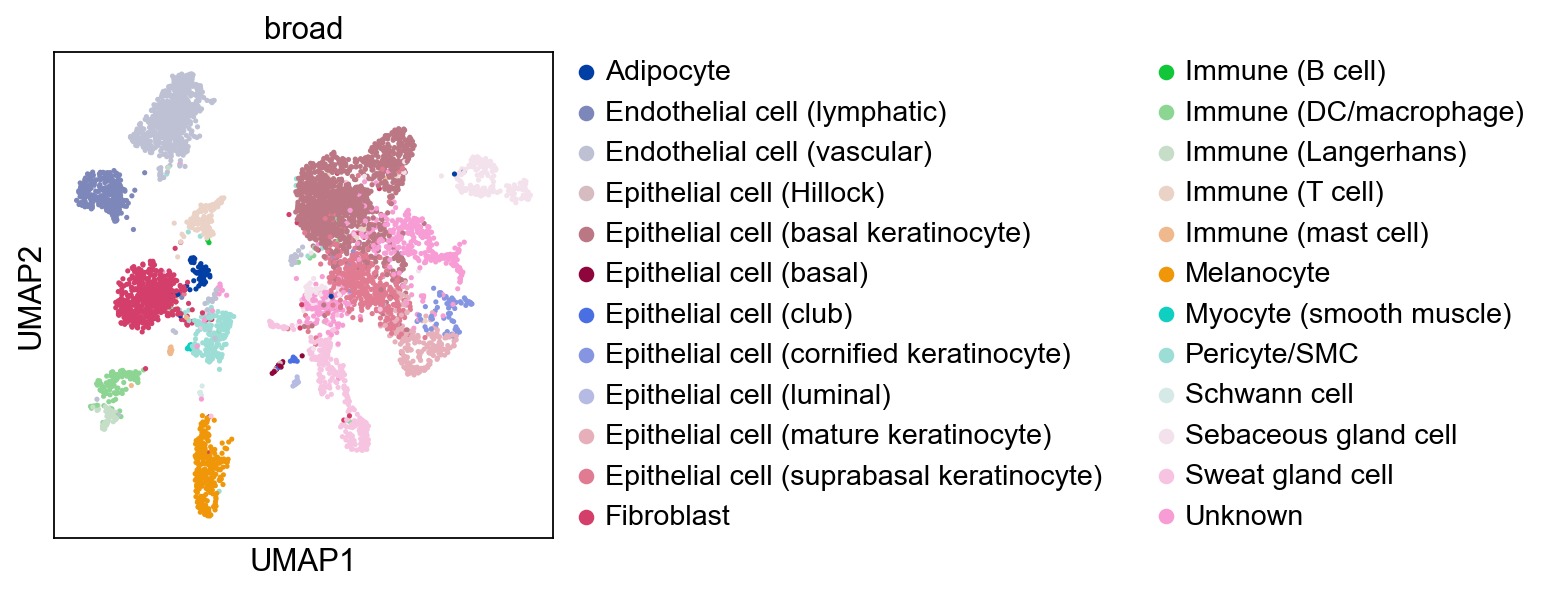

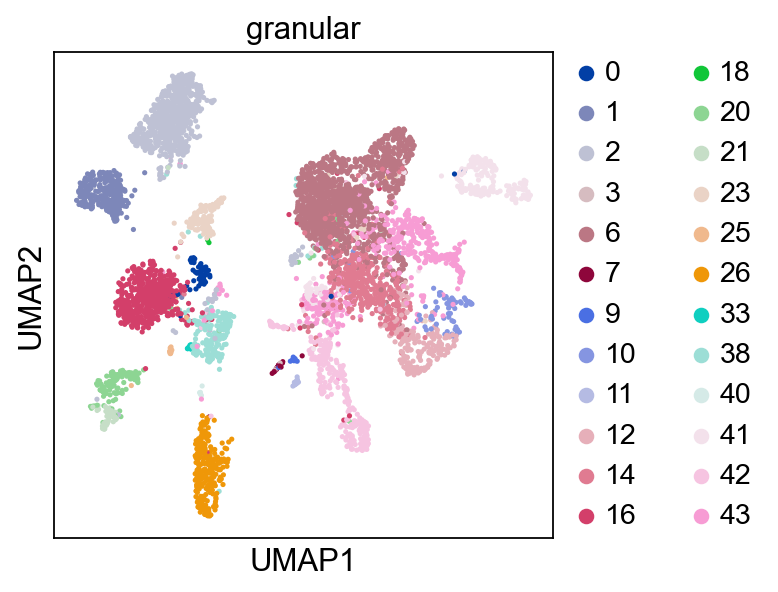

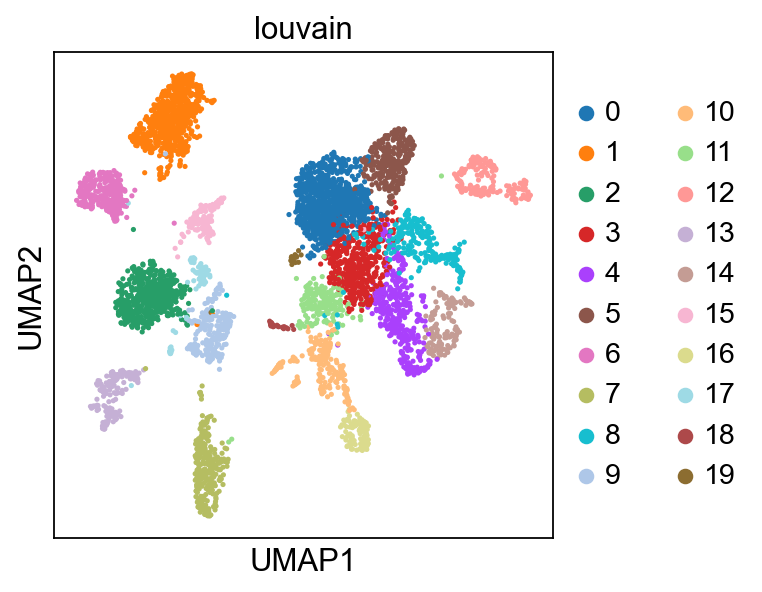

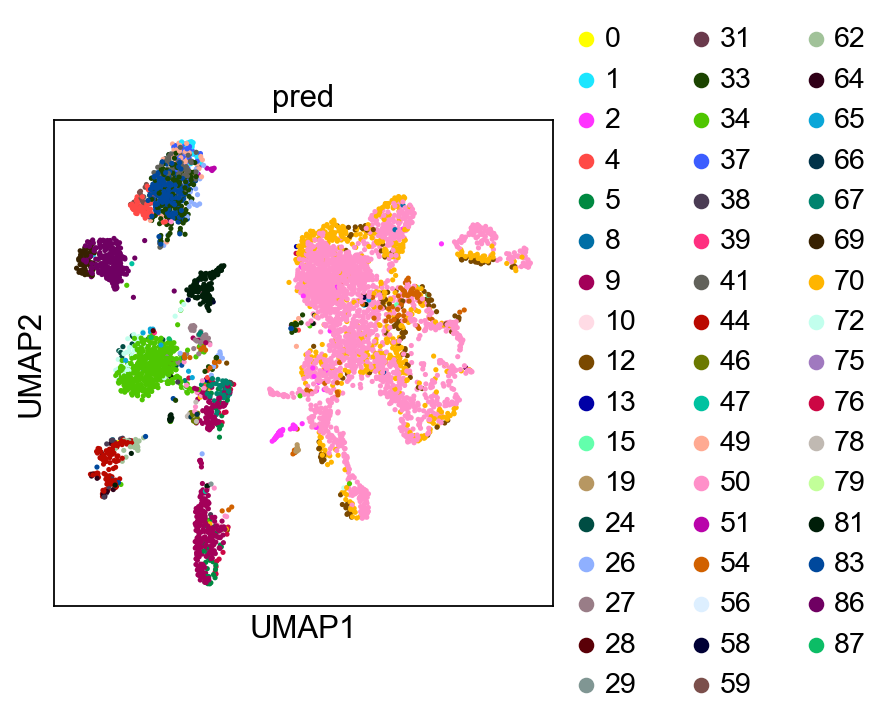

In [61]:
sc.pl.umap(cdata, color=["broad",])
sc.pl.umap(cdata, color=["granular",])
sc.pl.umap(cdata, color=["louvain",])
sc.pl.umap(cdata, color=["pred",])

In [62]:
output = model(data[-5500:])
cdata.obsm["z2"] = output["z"].detach().numpy()
cdata.obs["pred2"] = output["q_y"].detach().argmax(-1).numpy().astype(str)
del output
sc.pp.neighbors(cdata, use_rep="z2", n_neighbors=9)
sc.tl.umap(cdata,)
sc.tl.louvain(cdata,)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:05)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 21 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


/home/ykolb/miniconda3/envs/torch/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'pred2' as categorical


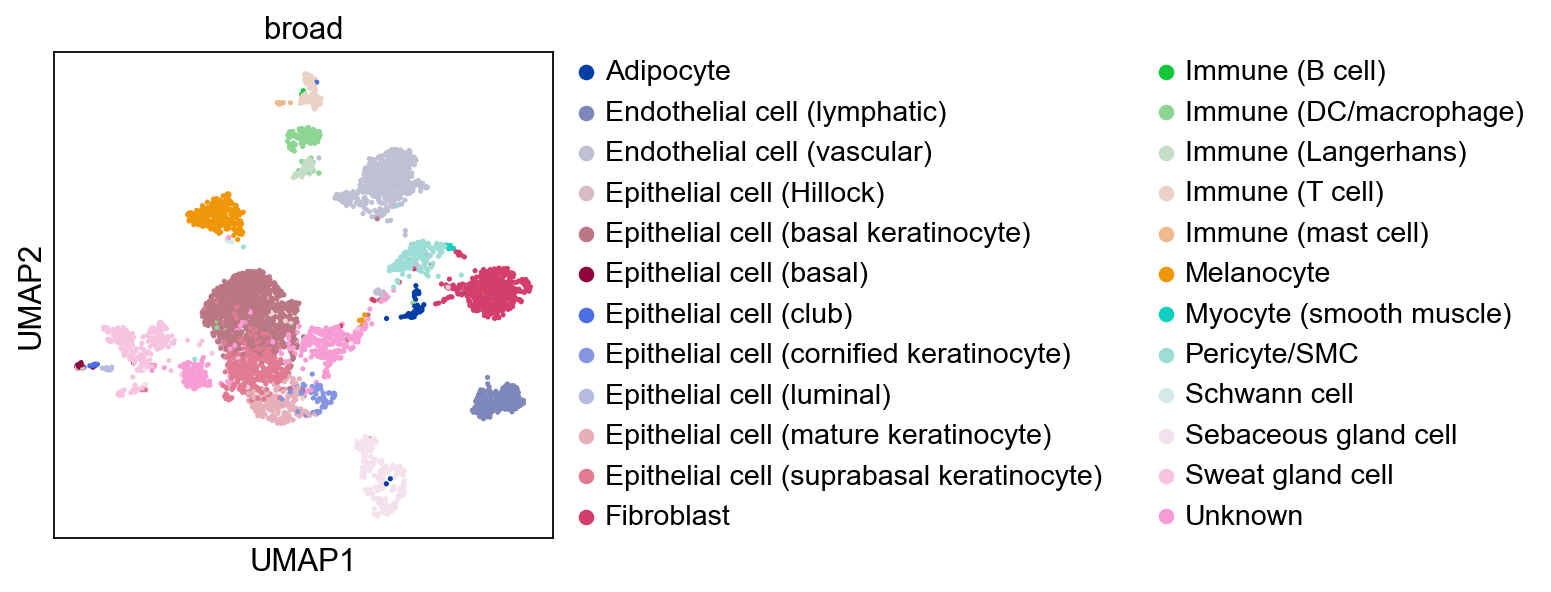

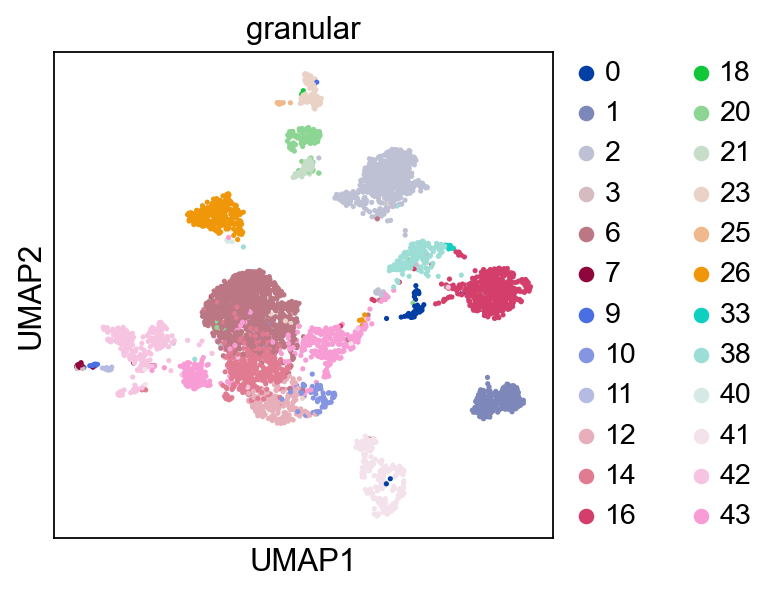

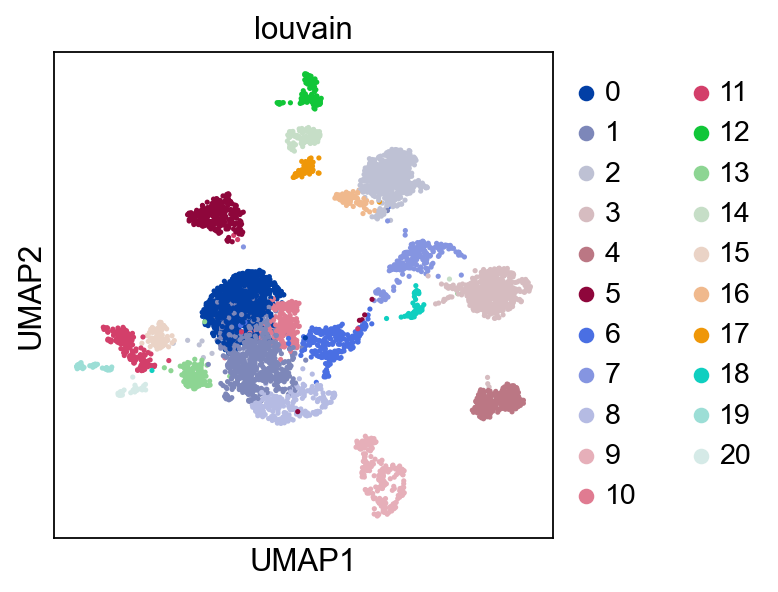

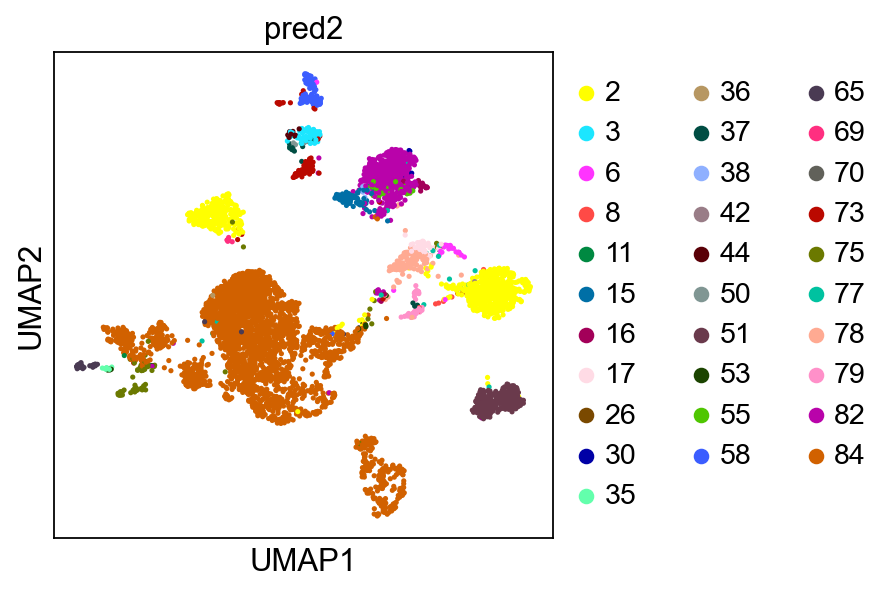

In [63]:
sc.pl.umap(cdata, color=["broad",])
sc.pl.umap(cdata, color=["granular",])
sc.pl.umap(cdata, color=["louvain",])
sc.pl.umap(cdata, color=["pred2",])


In [85]:
reload(M15)
model2 = M15.VAE_GMM_Type1503(
    nx=adata.n_vars,
    nh=1024*1,
    nhp=1024*1,
    nhq=1024*1,
    nz=64,
    nw=32,
    numhidden=2,
    numhiddenp=2,
    numhiddenq=2,
    dropout=0.2,
    use_resnet=False,
    nclasses=labels.shape[1],
    yscale=1e0,
    mi_scale=1e0,
    cc_scale=1e1,
    temperature=0.1,
    #restrict_w=True,
    #reclosstype="mse",
    #do_cc=True,
    softargmax=False,
    activation=nn.LeakyReLU(),
        )
#model2 = M15.VAE_Dirichlet_GMM_Type1502(
#    nx=adata.n_vars,
#    nh=1024*2,
#    nhp=1024*2,
#    nhq=1024*2,
#    nz=64,
#    nw=32,
#    numhidden=2,
#    numhiddenp=2,
#    numhiddenq=3,
#    dropout=0.2,
#    use_resnet=False,
#    nclasses=labels.shape[1],
#    yscale=1e0,
#    mi_scale=1e0,
#    cc_scale=1e1,
#    temperature=0.1,
#    restrict_w=True,
#    #reclosstype="mse",
#    #do_cc=True,
#    softargmax=False,
#    activation=nn.LeakyReLU(),
#)
#
#model2 = M7.VAE_Dirichlet_Type705(nx=adata.n_vars, nh=1024,
#        nz=64, nw=15, nclasses=enc_ct.classes_.size,)
model2.apply(init_weights)


True


VAE_GMM_Type1503(
  (Px): Sequential(
    (linear1): Linear(in_features=64, out_features=1024, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
    (batchnorm1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation1): LeakyReLU(negative_slope=0.01)
    (linear2): Linear(in_features=1024, out_features=1024, bias=True)
    (dropout2): Dropout(p=0.2, inplace=False)
    (batchnorm2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation2): LeakyReLU(negative_slope=0.01)
    (output_layer): Linear(in_features=1024, out_features=17695, bias=True)
  )
  (Pz): Sequential(
    (linear1): Linear(in_features=32, out_features=1024, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
    (batchnorm1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation1): LeakyReLU(negative_slope=0.01)
    (linear2): Linear(in_features=1024, out_features=1024, bias=True

In [86]:
Train.trainSemiSuperLoop(
    model2,
    train_loader_labeled=labeled_loader,
    train_loader_unlabeled=unlabeled_loader,
    test_loader=test_loader,
    num_epochs=50,
    #lrs=[1e-5,1e-4,1e-3,1e-4,1e-5],
    lrs=[1e-4,1e-3,1e-3,1e-4],
    wt=0,
    do_unlabeled=True,
    do_validation=True,
    report_interval=100,
    do_plot=False,
    test_accuracy=True,
)
    


epoch 0
labeled phase
rec: 19245.8359375
loss_z: 55.427066802978516
loss_w: 19.528247833251953
loss_cluster: -0.14152121543884277
loss_y: 4.757193088531494
total_loss: 19325.548828125
num_clusters: 0

[31. -1. -1. -1. 16. -1. 31. 31. -1. -1. 31. 16. -1. -1. -1. -1. -1. -1.
 31. -1. 20. -1. 16. 20. -1. -1. 31. 31. -1. -1. -1. 31. 32. -1. 31. 31.
 -1. -1. -1. 16. 31. -1. -1. -1.] 
 -0.24838923079041209 
 [ 1.         -1.         -1.         -1.          0.5        -1.
  1.          1.         -1.         -1.          0.91        1.
 -1.         -1.         -1.         -1.         -1.         -1.
  0.87096774 -1.          1.         -1.          1.          0.5
 -1.         -1.          1.          1.         -1.         -1.
 -1.          1.          1.         -1.          0.66666667  0.87323944
 -1.         -1.         -1.          0.25        0.5        -1.
 -1.         -1.        ]
1.0869565217391304 

unlabeled phase
rec: 18773.3671875
loss_z: 42.507049560546875
loss_w: 15.4454708099

ValueError: Expected parameter loc (Tensor of shape (256, 32)) of distribution Normal(loc: torch.Size([256, 32]), scale: torch.Size([256, 32])) to satisfy the constraint Real(), but found invalid values:
tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]], device='cuda:0',
       grad_fn=<SliceBackward0>)

In [77]:
M6.trainSemiSuper(model2, labeled_loader, unlabeled_loader, test_loader, 
        num_epochs=1, lr=1e-3, wt=0, do_unlabeled=True,)


labeled phase
rec: -2136.356201171875
loss_p: 15.826374053955078
loss_z: 34.930259704589844
loss_w: 8.192551612854004
loss_l: 0.0013245438458397985
loss_l_alt: 3.776249885559082
loss_y: -0.9987084269523621
loss_d: 0.0
loss_y_alt: 0.0013245438458397985
total_loss: -2093.232177734375
num_clusters: 9

unlabeled phase
rec: 2830.34130859375
loss_p: 16.285228729248047
loss_z: 20.441986083984375
loss_w: 4.7531280517578125
loss_l: 0.7064782977104187
loss_l_alt: 3.6569790840148926
loss_y: -0.9506909251213074
loss_d: 0.0
loss_y_alt: 15.656081199645996
total_loss: 2871.1923828125
num_clusters: 33

eval phase
rec: 4862.4052734375
loss_p: 15.765276908874512
loss_z: 119.73070526123047
loss_w: 3.512734889984131
loss_l: 13.755620002746582
loss_l_alt: 3.5289077758789062
loss_y: -0.9045709371566772
loss_d: 0.5143903493881226
loss_y_alt: 13.755620002746582
total_loss: 4999.91845703125
num_clusters: 21
ce loss: -14.762760162353516

labeled phase
rec: -2029.6280517578125
loss_p: 16.183731079101562
loss_z: 

In [78]:
output = model2(data[-5500:])
cdata.obsm["z3"] = output["z"].detach().numpy()
cdata.obs["pred3"] = output["q_y"].detach().argmax(-1).numpy().astype(str)
del output
sc.pp.neighbors(cdata, use_rep="z3", n_neighbors=9)
sc.tl.umap(cdata,)
sc.tl.louvain(cdata,)


computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:05)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 14 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


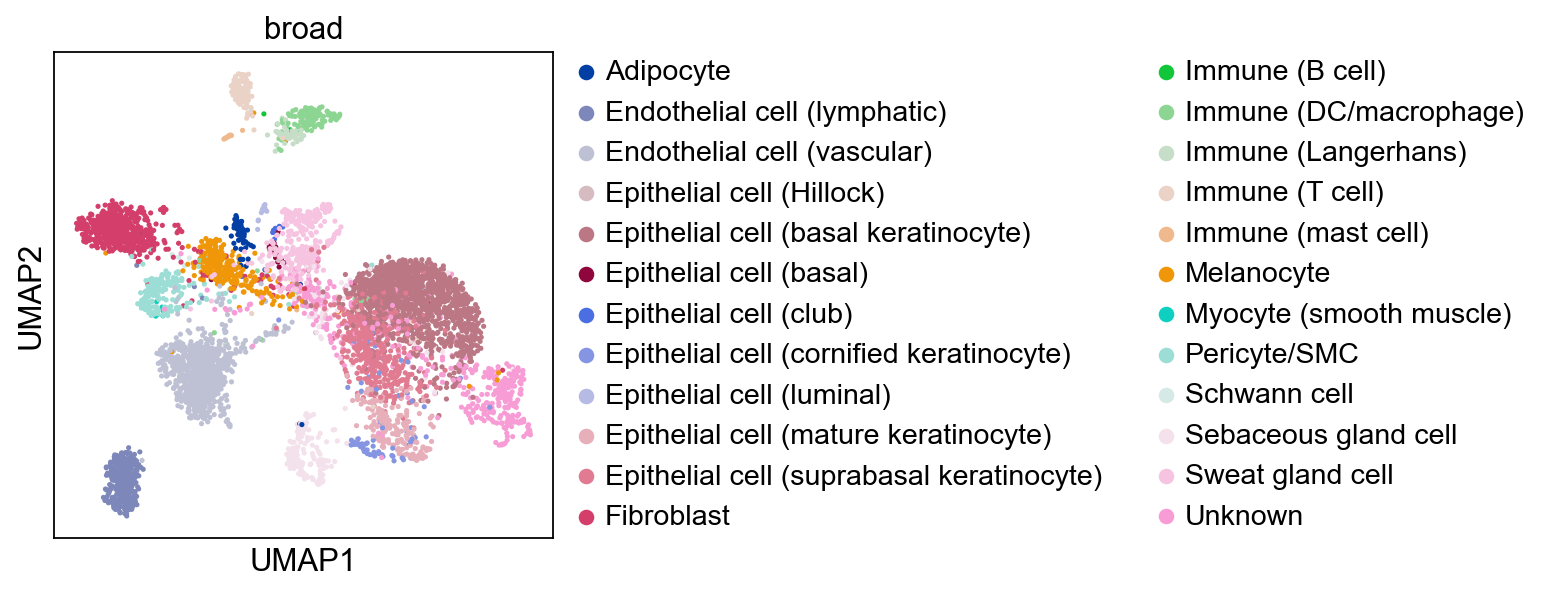

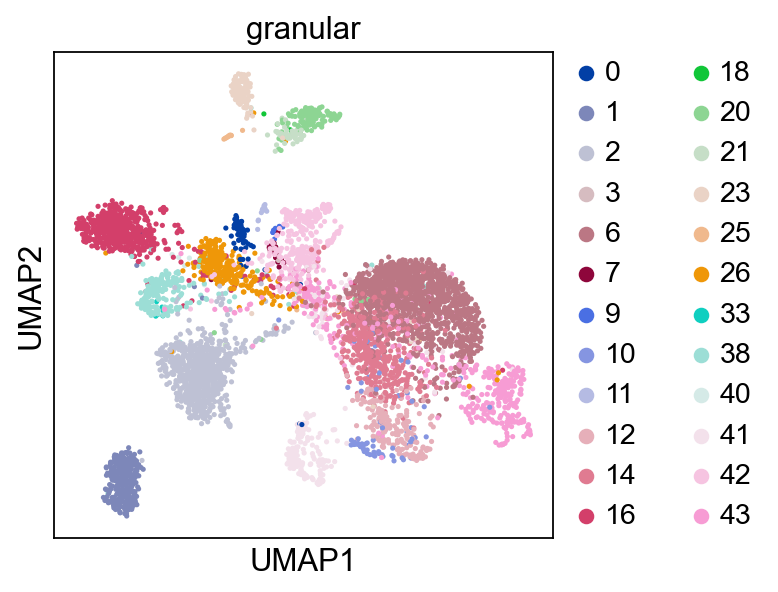

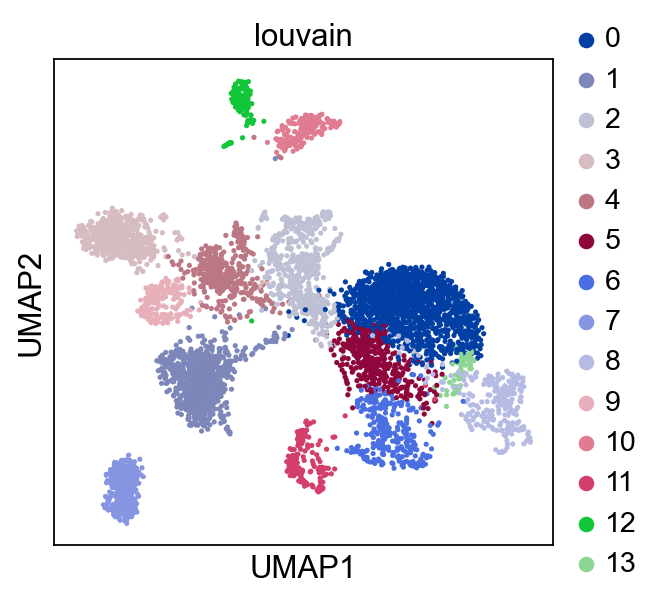

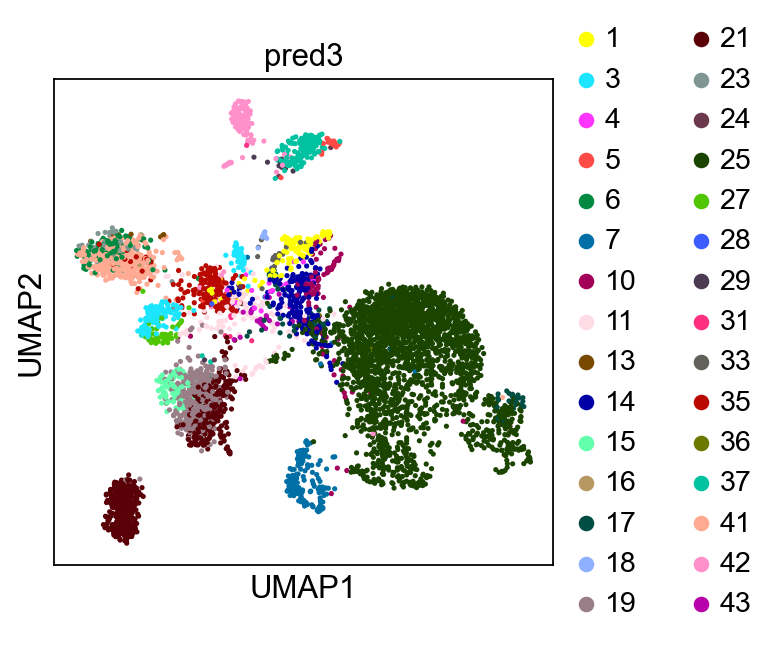

In [80]:
sc.pl.umap(cdata, color=["broad",])
sc.pl.umap(cdata, color=["granular",])
sc.pl.umap(cdata, color=["louvain",])
sc.pl.umap(cdata, color=["pred3",])
